In [1]:
from tesspy import Tessellation, tessellation_functions
import geopandas as gpd
import pandas as pd
from shapely.geometry import box
from shapely import intersects
import mercantile
import matplotlib.pyplot as plt
import numpy as np
from libpysal import weights
import networkx as nx
from matplotlib.cm import ScalarMappable
import math

In [2]:
gdf_all = gpd.read_file("files/departments/all_deps.shp")
gdf_all.crs = "epsg:4326"

In [3]:
LARGE_ZOOM_LEVEL = 13
MEDIUM_ZOOM_LEVEL = 14
SMALL_ZOOM_LEVEL = 15

In [4]:
deps = Tessellation(gdf_all)

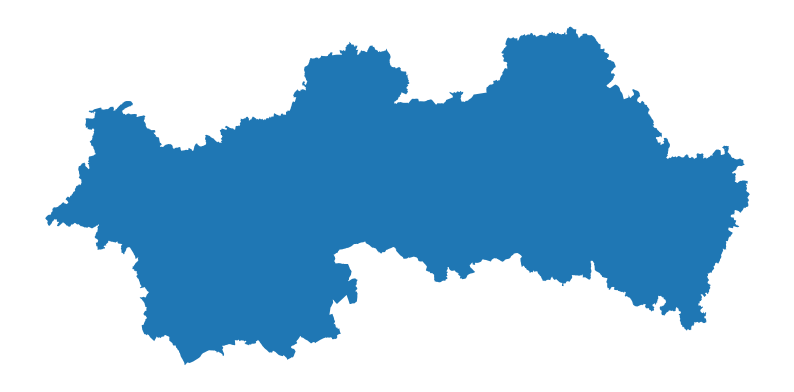

In [5]:
deps.get_polygon().plot(figsize=(10, 10)).set_axis_off()

In [6]:
deps_large = tessellation_functions.get_squares_polyfill(
    deps.area_gdf, LARGE_ZOOM_LEVEL
)

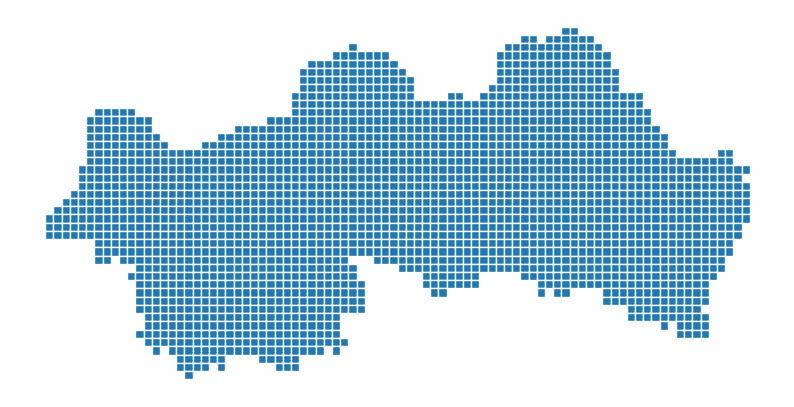

In [7]:
deps_large.plot(lw=1, edgecolor="w", figsize=(10, 10)).set_axis_off()

In [8]:
gdf_periurban = gpd.read_file("files/periurban/periurban.shp")
gdf_periurban.crs = "epsg:4326"

In [9]:
def intersects_filter(row):
    return intersects(row["geometry"], gdf_periurban["geometry"])

In [10]:
large_tiles_periurban = deps_large[deps_large.apply(intersects_filter, axis=1)[0]]

<Axes: >

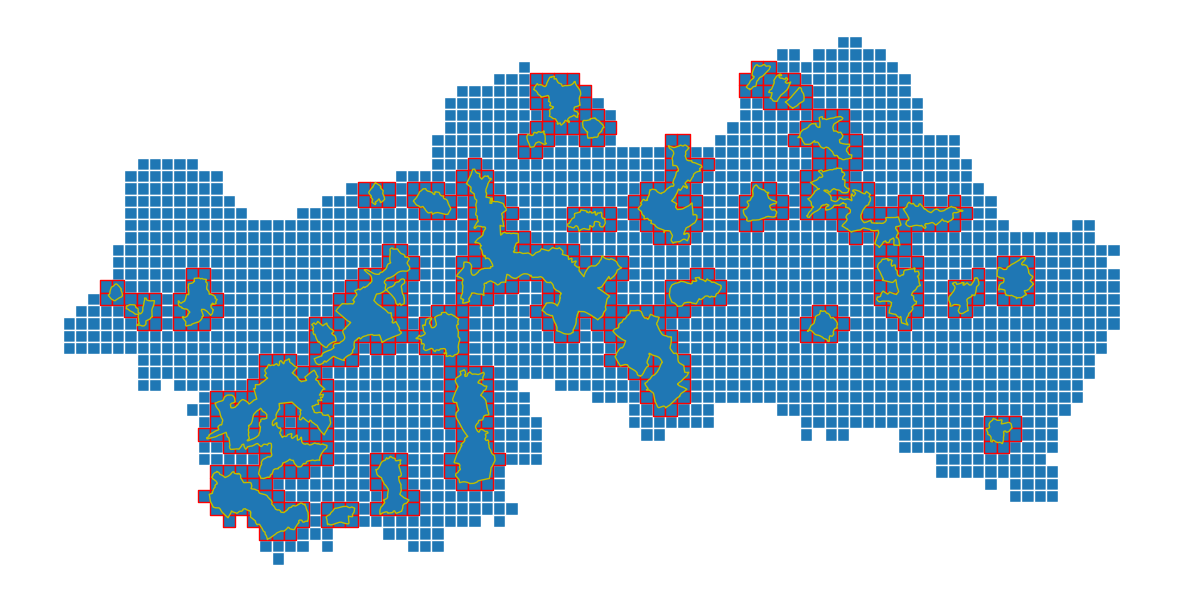

In [11]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban.plot(ax=ax, lw=1, edgecolor="r", figsize=(15, 15)).set_axis_off()
gdf_periurban.plot(edgecolor="y", ax=ax)

In [12]:
deps_large["index_copy"] = deps_large.index

In [13]:
gdf_joined = gpd.overlay(gdf_periurban, deps_large, how="intersection")

In [14]:
gdf_joined.set_index("index_copy", inplace=True)

In [15]:
large_tiles_periurban["periurban_area_proportion"] = (
    gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
)

/tmp/ipykernel_5185/1165391927.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_joined.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [16]:
large_tiles_periurban_filtered = large_tiles_periurban[
    large_tiles_periurban["periurban_area_proportion"] >= 0.5
]

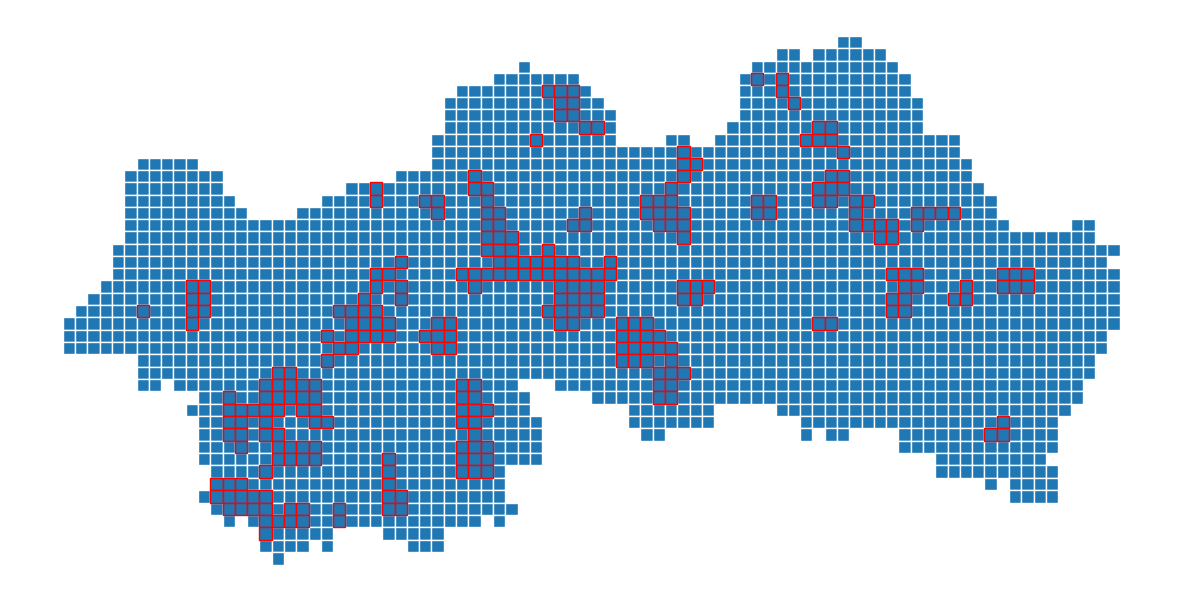

In [17]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_periurban_filtered.plot(
    ax=ax, lw=1, edgecolor="r", figsize=(15, 15)
).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [18]:
def split_tile_to_zoom(tile_row, zoom_level):
    rows = []
    bbox = tile_row.geometry.bounds
    medium_tiles = mercantile.tiles(bbox[0], bbox[1], bbox[2], bbox[3], zoom_level)
    for tile in medium_tiles:
        square = box(*mercantile.bounds(tile))
        rows.append(square)
    return rows


def get_tiles_for_level(base_tiles_df, zoom_level, tile_type):
    new_rows = []
    for row in base_tiles_df.apply(
        lambda row: split_tile_to_zoom(row, zoom_level), axis=1
    ):
        new_rows.extend(row)
    new_df = pd.DataFrame(new_rows, columns=["geometry"])
    new_df["type"] = tile_type
    return gpd.GeoDataFrame(new_df, geometry="geometry", crs="epsg:4326")

In [19]:
medium_tiles = get_tiles_for_level(
    large_tiles_periurban_filtered, MEDIUM_ZOOM_LEVEL, "periurban"
)

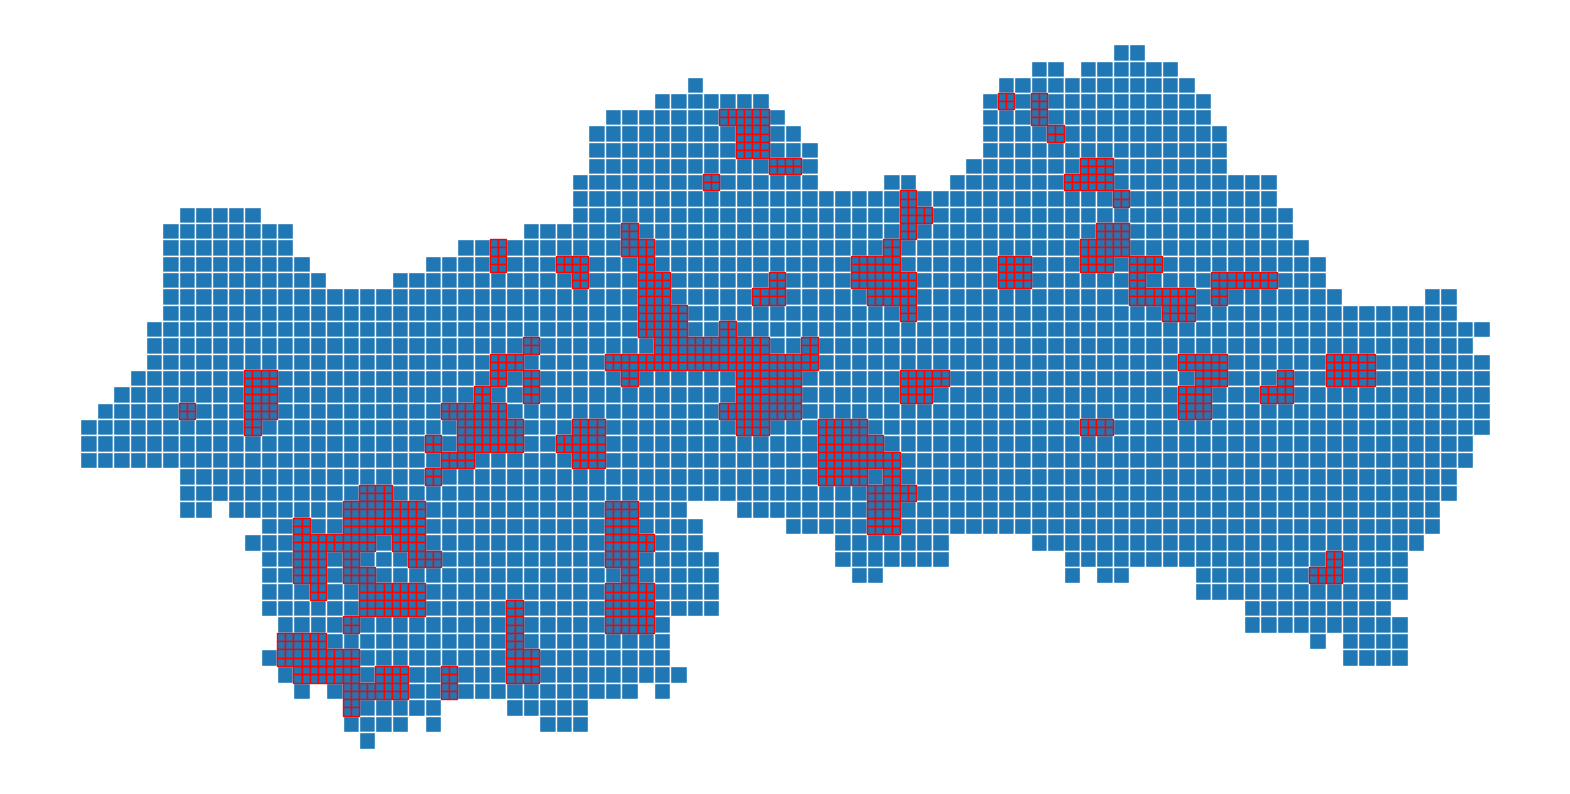

In [20]:
f, ax = plt.subplots(figsize=(20, 20))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(20, 20)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
# gdf_periurban.plot(edgecolor="y", ax=ax)

In [21]:
gdf_urban = gpd.read_file("files/urban/urban.shp")
gdf_urban.crs = "epsg:4326"


def urban_intersects_filter(row):
    return intersects(row["geometry"], gdf_urban["geometry"])


large_tiles_urban = deps_large[deps_large.apply(urban_intersects_filter, axis=1)[0]]

<Axes: >

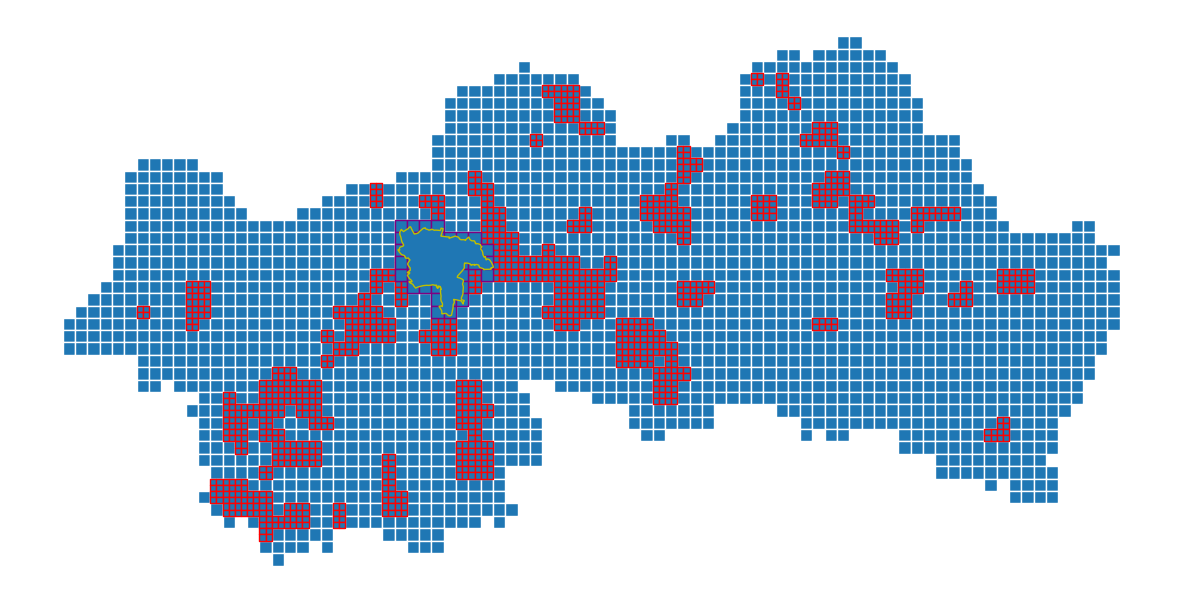

In [22]:
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(20, 20)).set_axis_off()
large_tiles_urban.plot(ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

/tmp/ipykernel_5185/3217006072.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

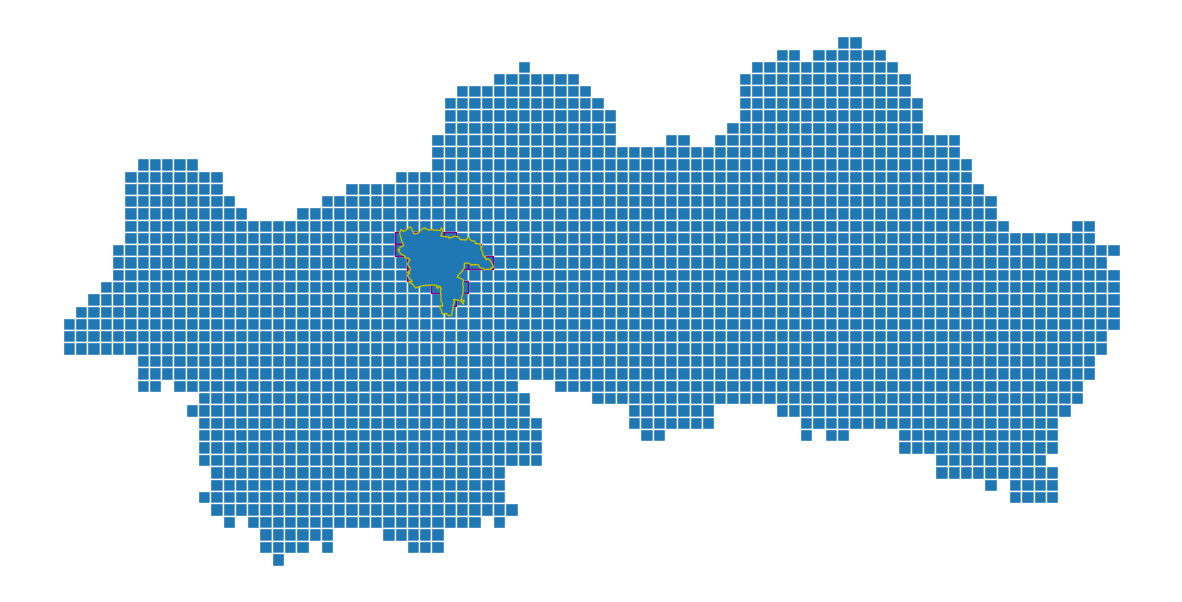

In [23]:
deps_large["index_copy"] = deps_large.index
gdf_joined_urban = gpd.overlay(gdf_urban, deps_large, how="intersection")
gdf_joined_urban.set_index("index_copy", inplace=True)
large_tiles_urban["urban_area_proportion"] = (
    gdf_joined_urban.to_crs(epsg=4326).area / deps_large.to_crs(epsg=4326).area
)
large_tiles_urban_filtered = large_tiles_urban[
    large_tiles_urban["urban_area_proportion"] >= 0.5
]
f, ax = plt.subplots(figsize=(15, 15))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(15, 15)).set_axis_off()
large_tiles_urban_filtered.plot(
    ax=ax, lw=1, edgecolor="purple", figsize=(15, 15)
).set_axis_off()
gdf_urban.plot(edgecolor="y", ax=ax)

In [24]:
small_tiles = get_tiles_for_level(large_tiles_urban_filtered, SMALL_ZOOM_LEVEL, "urban")

<Axes: >

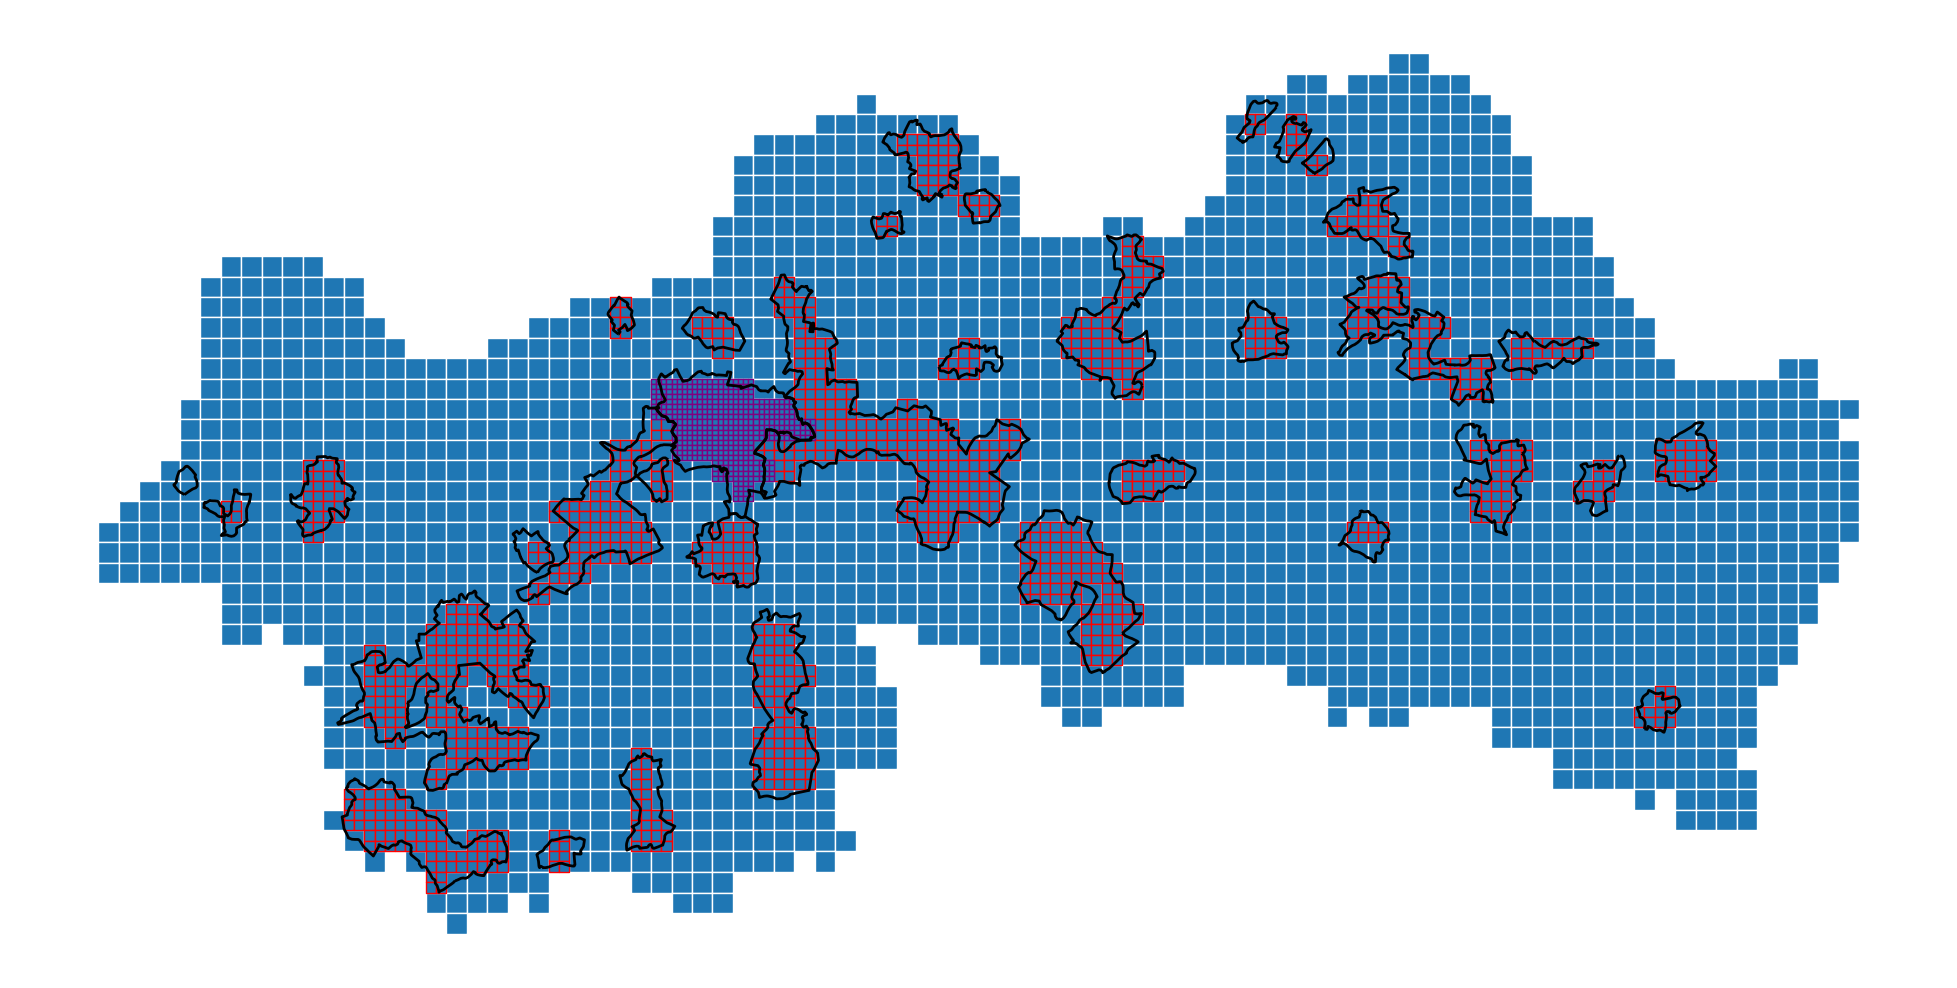

In [25]:
f, ax = plt.subplots(figsize=(25, 25))
deps_large.plot(ax=ax, lw=1, edgecolor="w", figsize=(25, 25)).set_axis_off()
medium_tiles.plot(ax=ax, lw=1, edgecolor="r", figsize=(25, 25)).set_axis_off()
small_tiles.plot(ax=ax, lw=1, edgecolor="purple", figsize=(25, 25)).set_axis_off()
gdf_urban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")
gdf_periurban.plot(ax=ax, lw=2, edgecolor="black", facecolor="none")

## From tiles to network

In [26]:
centroids = np.column_stack((deps_large.centroid.x, deps_large.centroid.y))
queen = weights.Rook.from_dataframe(deps_large)
graph = queen.to_networkx()
positions = dict(zip(graph.nodes, centroids))

/tmp/ipykernel_5185/158546080.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = np.column_stack((deps_large.centroid.x, deps_large.centroid.y))
/tmp/ipykernel_5185/158546080.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  queen = weights.Rook.from_dataframe(deps_large)


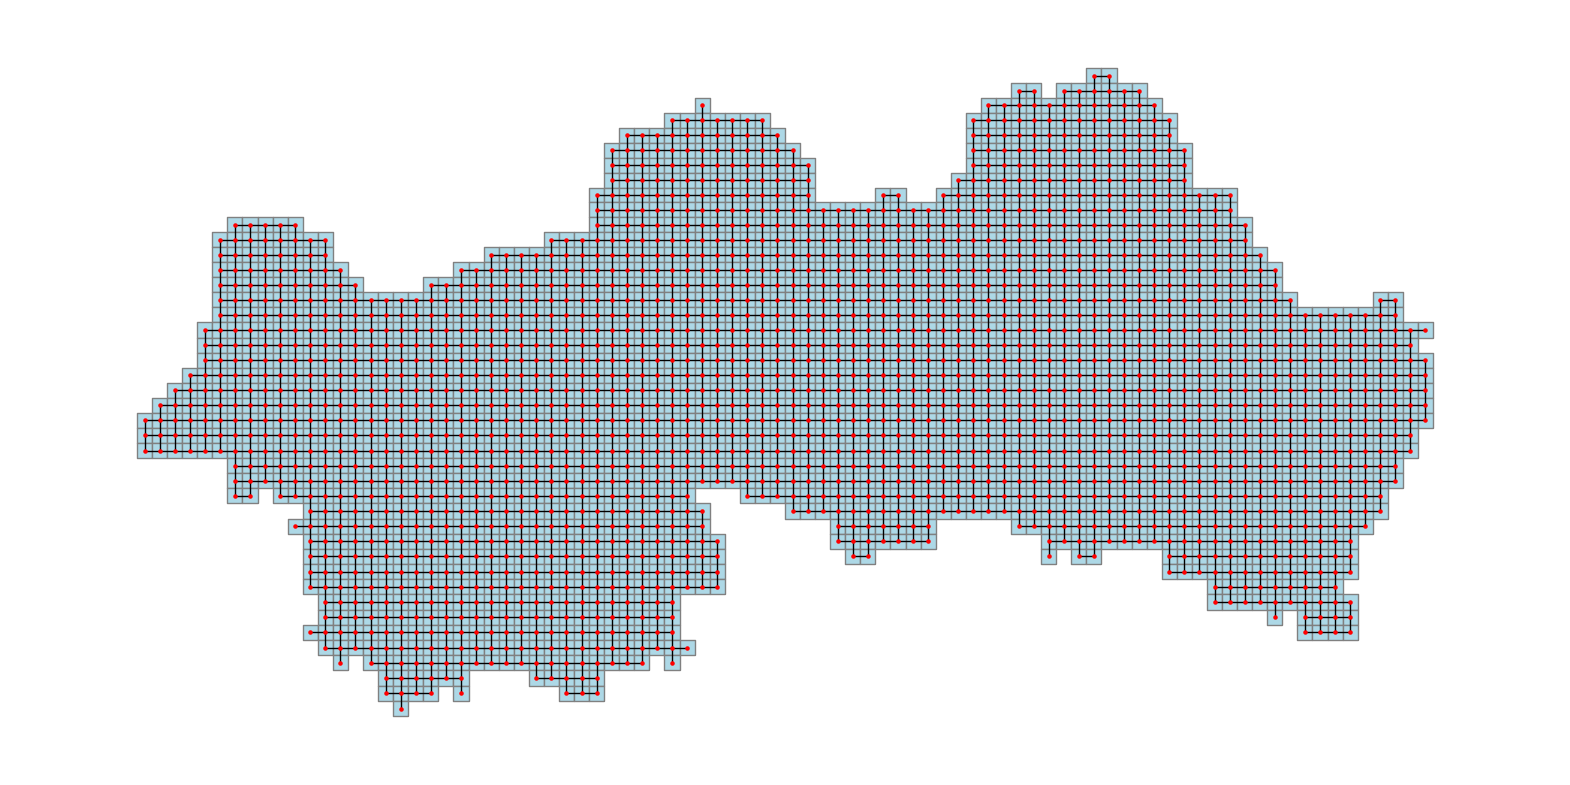

In [27]:
# plot with a nice basemap
ax = deps_large.plot(
    linewidth=1, edgecolor="grey", figsize=(20, 20), facecolor="lightblue"
)
nx.draw(graph, positions, ax=ax, node_size=5, node_color="r")
plt.show()

## Put together different-sized tiles

In [28]:
tiles_df = deps_large[["geometry"]].copy()

In [29]:
in_medium = tiles_df.index.isin(large_tiles_periurban_filtered.index)
tiles_df = tiles_df[~in_medium]

In [30]:
in_small = tiles_df.index.isin(large_tiles_urban_filtered.index)
tiles_df = tiles_df[~in_small]

<Axes: >

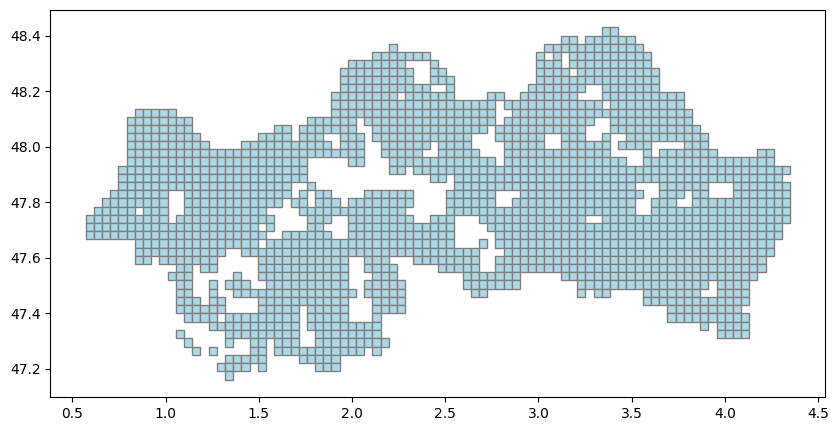

In [31]:
tiles_df.plot(linewidth=1, edgecolor="grey", figsize=(10, 10), facecolor="lightblue")

In [32]:
tiles_df["type"] = "rural"

In [33]:
tiles_df = pd.concat([tiles_df, small_tiles, medium_tiles])
tiles_df = tiles_df.reset_index(drop=True)
tiles_df["tile_id"] = tiles_df.index

In [34]:
tiles_df.shape

(3423, 3)

<Axes: >

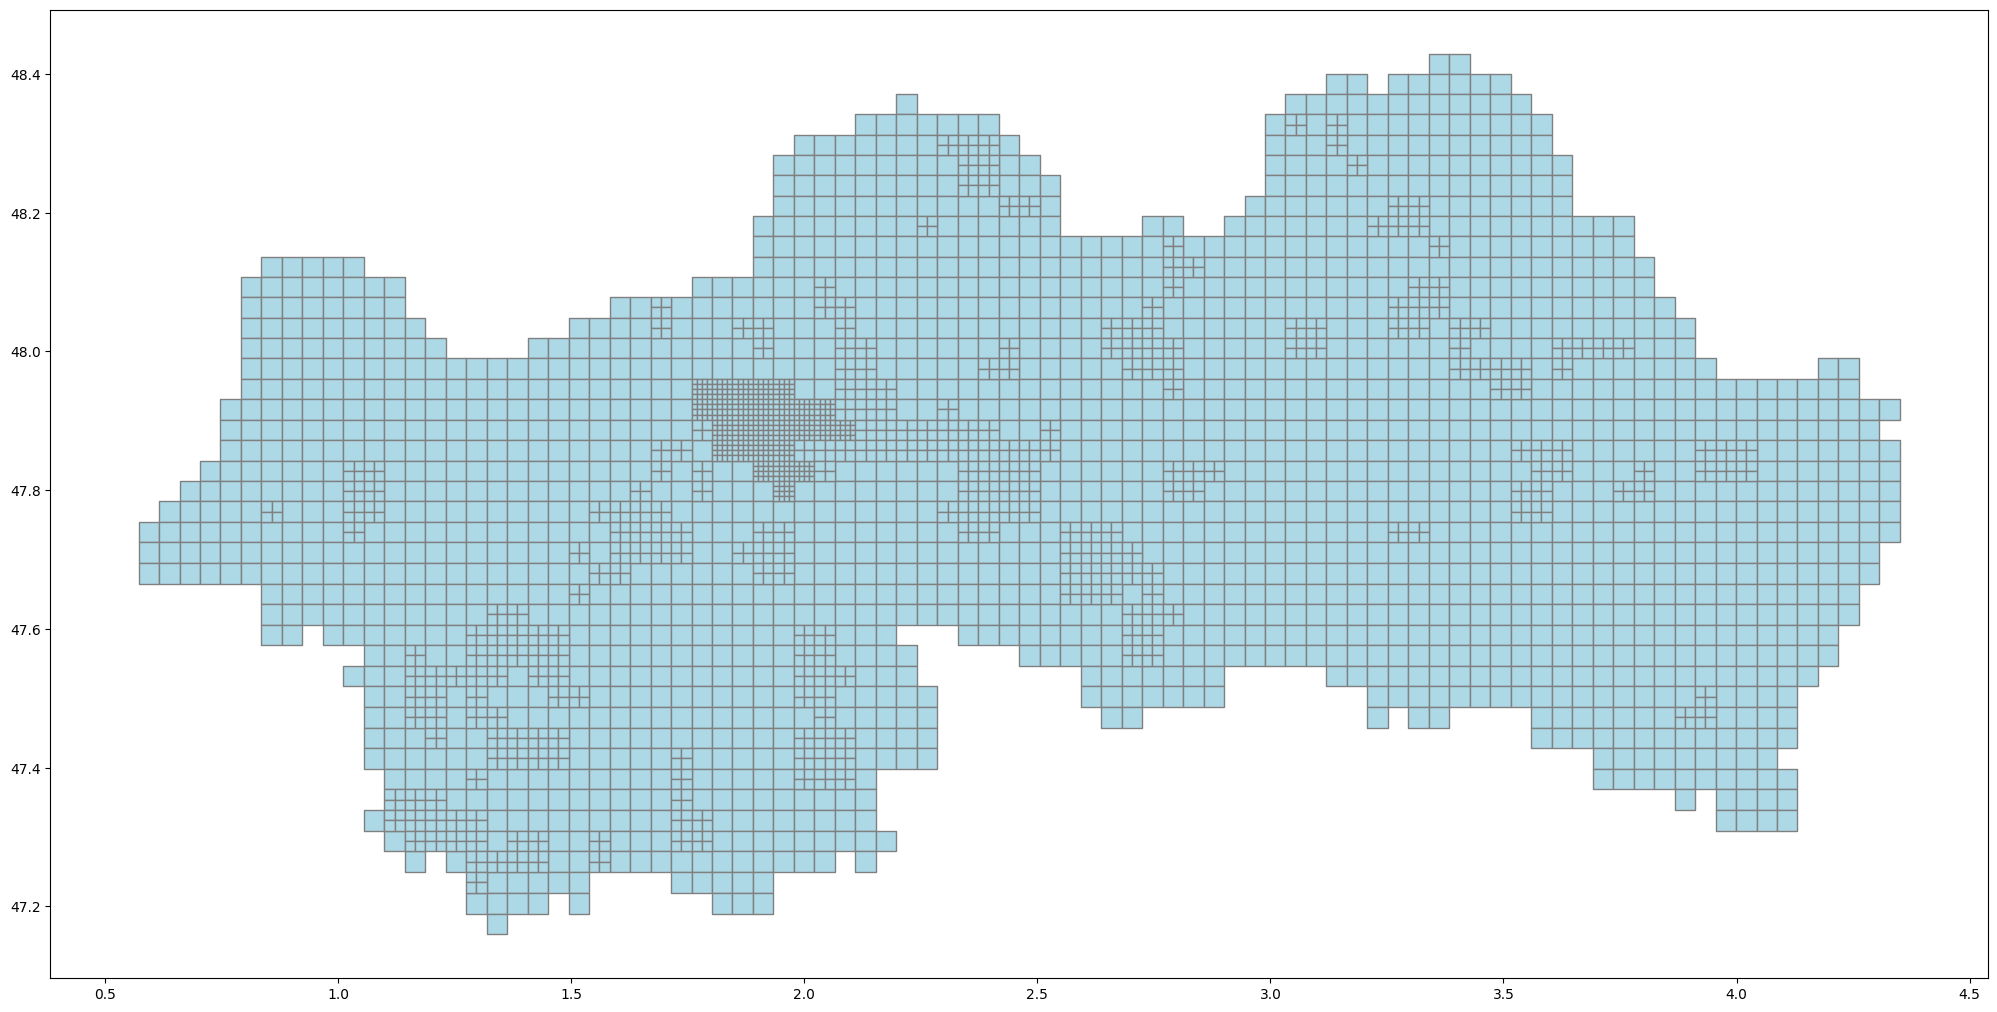

In [35]:
tiles_df.plot(linewidth=1, edgecolor="grey", figsize=(25, 25), facecolor="lightblue")

In [36]:
tiles_df["type"].value_counts()

type
rural        1807
periurban    1184
urban         432
Name: count, dtype: int64

## Measurements

In [37]:
df_measurements = pd.read_csv("files/measurements.csv", delimiter=";")

In [38]:
MIN_THRESHOLD_ALL = dict(rural=2, periurban=2, urban=1)
MIN_THRESHOLD_4G = dict(rural=3, periurban=2, urban=1)
MIN_THRESHOLD_5G = dict(rural=3, periurban=2, urban=1)

## All measurements

In [39]:
gdf_measurements_all = gpd.GeoDataFrame(
    df_measurements, geometry=gpd.points_from_xy(df_measurements.X, df_measurements.Y)
)
gdf_measurements_all.crs = "epsg:2154"  # lambert 93
gdf_measurements_all = gdf_measurements_all.to_crs("epsg:4326")

<Axes: >

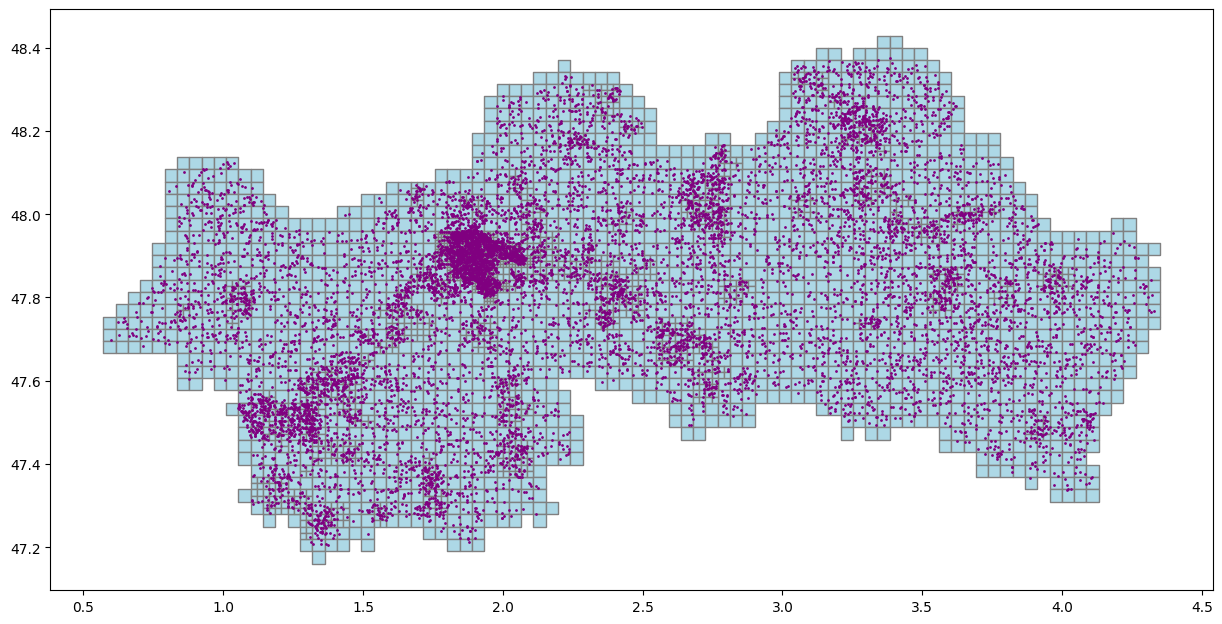

In [40]:
f, ax = plt.subplots(figsize=(15, 15))
tiles_df.plot(
    ax=ax, linewidth=1, edgecolor="grey", figsize=(15, 15), facecolor="lightblue"
)
gdf_measurements_all.plot(ax=ax, markersize=1, color="purple")

In [41]:
gdf_measurements_all.head()

ID       X        Y Techno operateur  dbm Puissance recue  \
0  OP1_4G_1  528480  6734006     4G       OP1 -122        Mauvaise   
1  OP1_4G_2  532425  6735325     4G       OP1 -114         Moyenne   
2  OP1_4G_3  534492  6734651     4G       OP1  -39           Bonne   
3  OP1_4G_4  534096  6736042     4G       OP1  -40           Bonne   
4  OP1_4G_5  535524  6734374     4G       OP1 -115         Moyenne   

                   geometry  
0  POINT (0.71348 47.68409)  
1  POINT (0.76555 47.69697)  
2  POINT (0.79335 47.69143)  
3  POINT (0.78755 47.70385)  
4  POINT (0.80720 47.68920)

In [42]:
def add_measurements_count(
    input_df,
    measurements_df,
    threshold_use,
    id_column="tile_id",
    point_count_name="points_count",
):
    base_df = input_df.copy()
    original_index = base_df.index
    if original_index.name == id_column:
        base_df = base_df.reset_index()

    gdf_sjoined = gpd.sjoin(base_df, measurements_df, how="inner")

    aggregations = {}
    aggregations["ID"] = "size"
    aggregations["dbm"] = "mean"
    aggregations["operateur"] = lambda ops: set(ops)

    gdf_tiles_measures = (
        gdf_sjoined[[id_column, "ID", "dbm", "operateur"]]
        .set_index(id_column)
        .groupby(id_column)
        .agg(aggregations)
        .rename(
            columns={
                "ID": point_count_name,
                "dbm": f"meandbm_{point_count_name}",
                "operateur": f"operators_{point_count_name}",
            }
        )
    )
    # print(gdf_tiles_measures.columns)

    # gdf_tiles_measures = (
    #     gpd.sjoin(base_df, measurements_df, how="inner")
    #     .groupby(id_column)
    #     .size()
    #     .rename(point_count_name)
    # )

    joined_df = (
        base_df.set_index(id_column)
        .join(gdf_tiles_measures, how="left")
        .fillna({point_count_name: 0})
    )

    if original_index.name != id_column:
        # Avoids duplicating polygon_id as column and index
        joined_df = joined_df.reset_index()
    joined_df = joined_df.set_index(original_index)  # Restore the original index
    joined_df[f"use_{count_col_name}"] = joined_df[point_count_name] >= joined_df[
        "type"
    ].map(lambda tile_type: threshold_use[tile_type])

    return joined_df

In [43]:
count_col_name = "total_measurements"
tiles_with_counts = add_measurements_count(
    tiles_df,
    gdf_measurements_all,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_ALL,
)
tiles_with_counts.shape

(3423, 7)

In [44]:
tiles_with_counts.head()

tile_id                                           geometry   type  \
0        0  POLYGON ((0.61523 47.72454, 0.61523 47.75410, ...  rural   
1        1  POLYGON ((0.61523 47.69497, 0.61523 47.72454, ...  rural   
2        2  POLYGON ((0.61523 47.66539, 0.61523 47.69497, ...  rural   
3        3  POLYGON ((0.65918 47.75410, 0.65918 47.78363, ...  rural   
4        4  POLYGON ((0.65918 47.72454, 0.65918 47.75410, ...  rural   

   total_measurements  meandbm_total_measurements  \
0                 0.0                         NaN   
1                 1.0                  -98.000000   
2                 0.0                         NaN   
3                 0.0                         NaN   
4                 6.0                  -79.666667   

  operators_total_measurements  use_total_measurements  
0                          NaN                   False  
1                        {OP3}                   False  
2                          NaN                   False  
3                          NaN                   False  
4              {OP4, OP2, OP3}                    True

In [45]:
colors = dict(
    red=(1.0, 0.7, 0.7, 0.2),  # Pastel red with 50% opacity
    pink=(1.0, 0.8, 0.85, 0.1),  # Pastel pink with 50% opacity
    yellow=(1.0, 0.95, 0.7, 0.1),  # Pastel yellow with 50% opacity
)


def get_colormap(use):
    if use:
        return "lightblue"
    else:
        return "azure"


def get_linewidth_map(use):
    if use:
        return 1
    else:
        return 1

In [46]:
count_col_name = "total_measurements"
tiles_with_counts = add_measurements_count(
    tiles_df,
    gdf_measurements_all,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_ALL,
)
tiles_with_counts.shape

(3423, 7)

<Axes: >

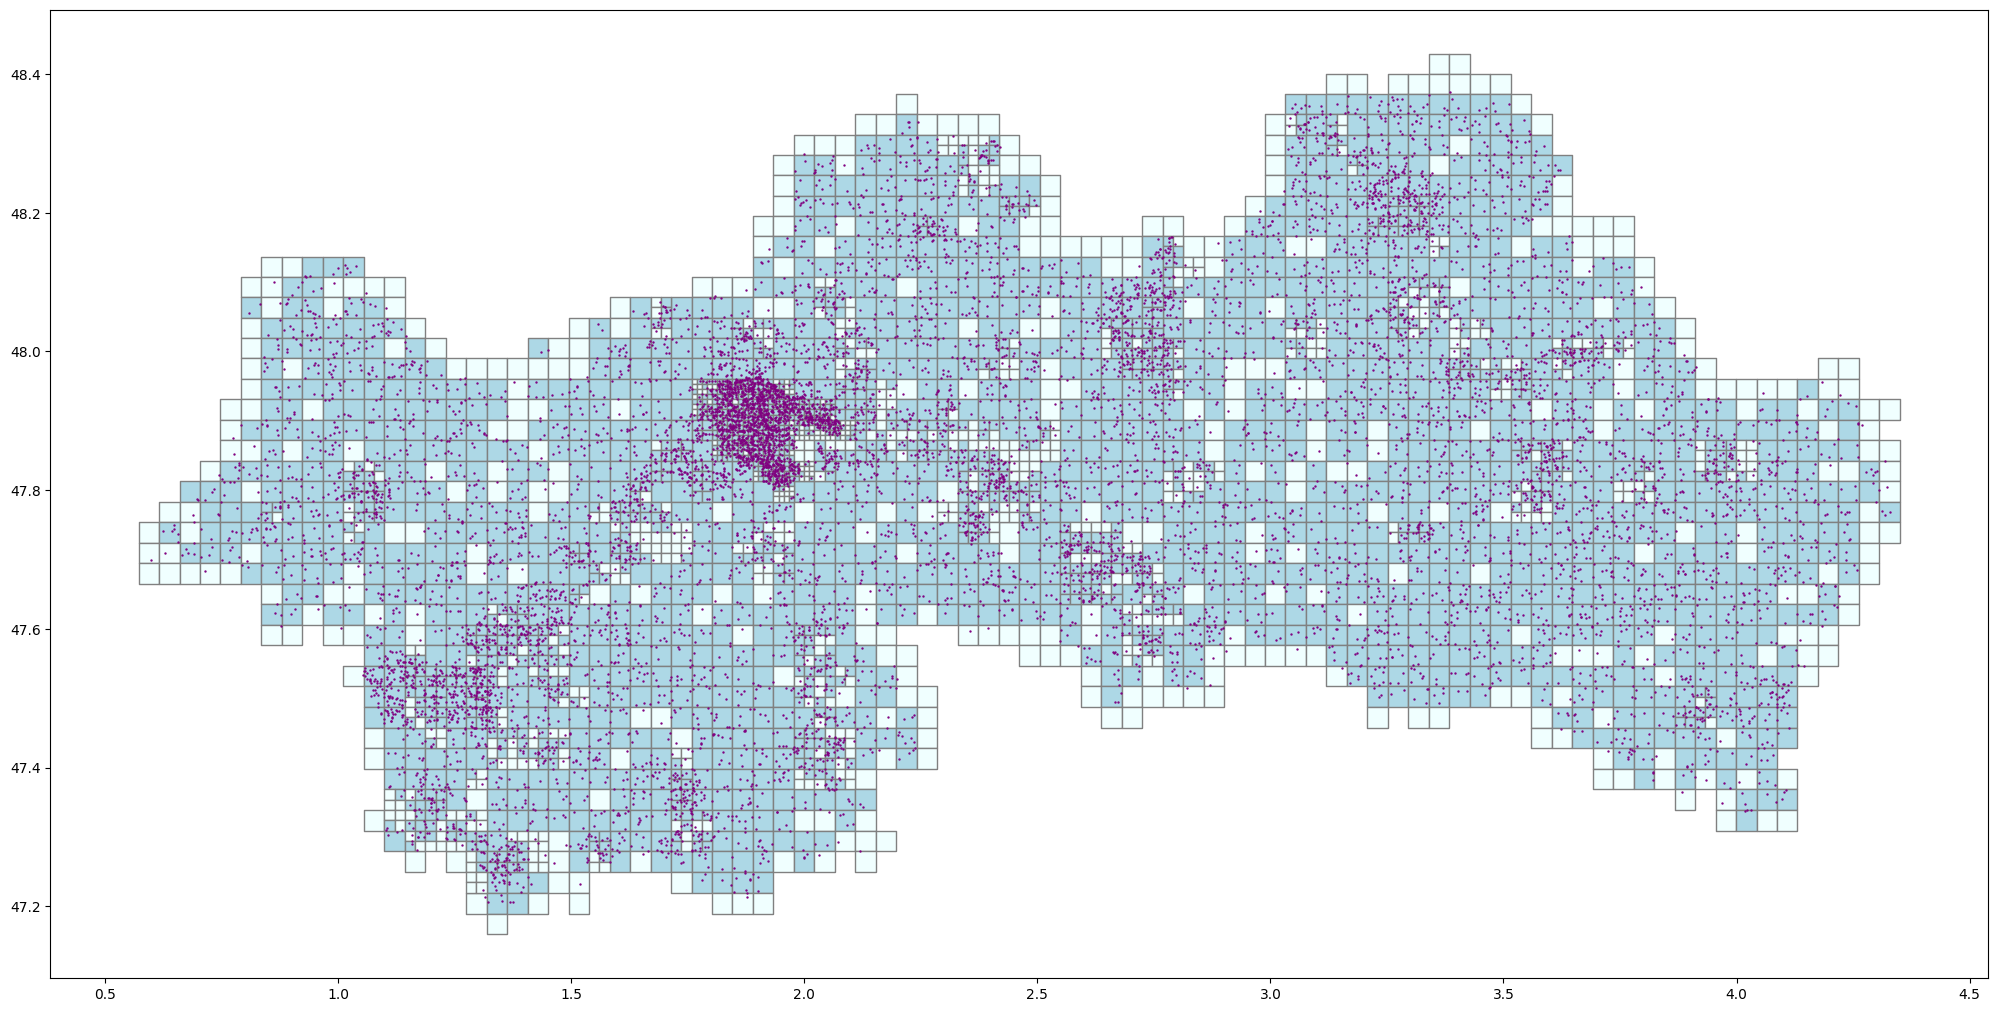

In [47]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
)
gdf_measurements_all.plot(ax=ax, markersize=0.5, color="purple")

## Split 4G and 5G

In [48]:
gdf_measurements_4g = (
    gdf_measurements_all[gdf_measurements_all["Techno"] == "4G"].copy().reset_index()
)
gdf_measurements_5g = (
    gdf_measurements_all[gdf_measurements_all["Techno"] == "5G"].copy().reset_index()
)

In [49]:
count_col_name = "4g_measurements"
tiles_with_counts = add_measurements_count(
    tiles_with_counts,
    gdf_measurements_4g,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_4G,
)
tiles_with_counts.shape

(3423, 11)

<Axes: >

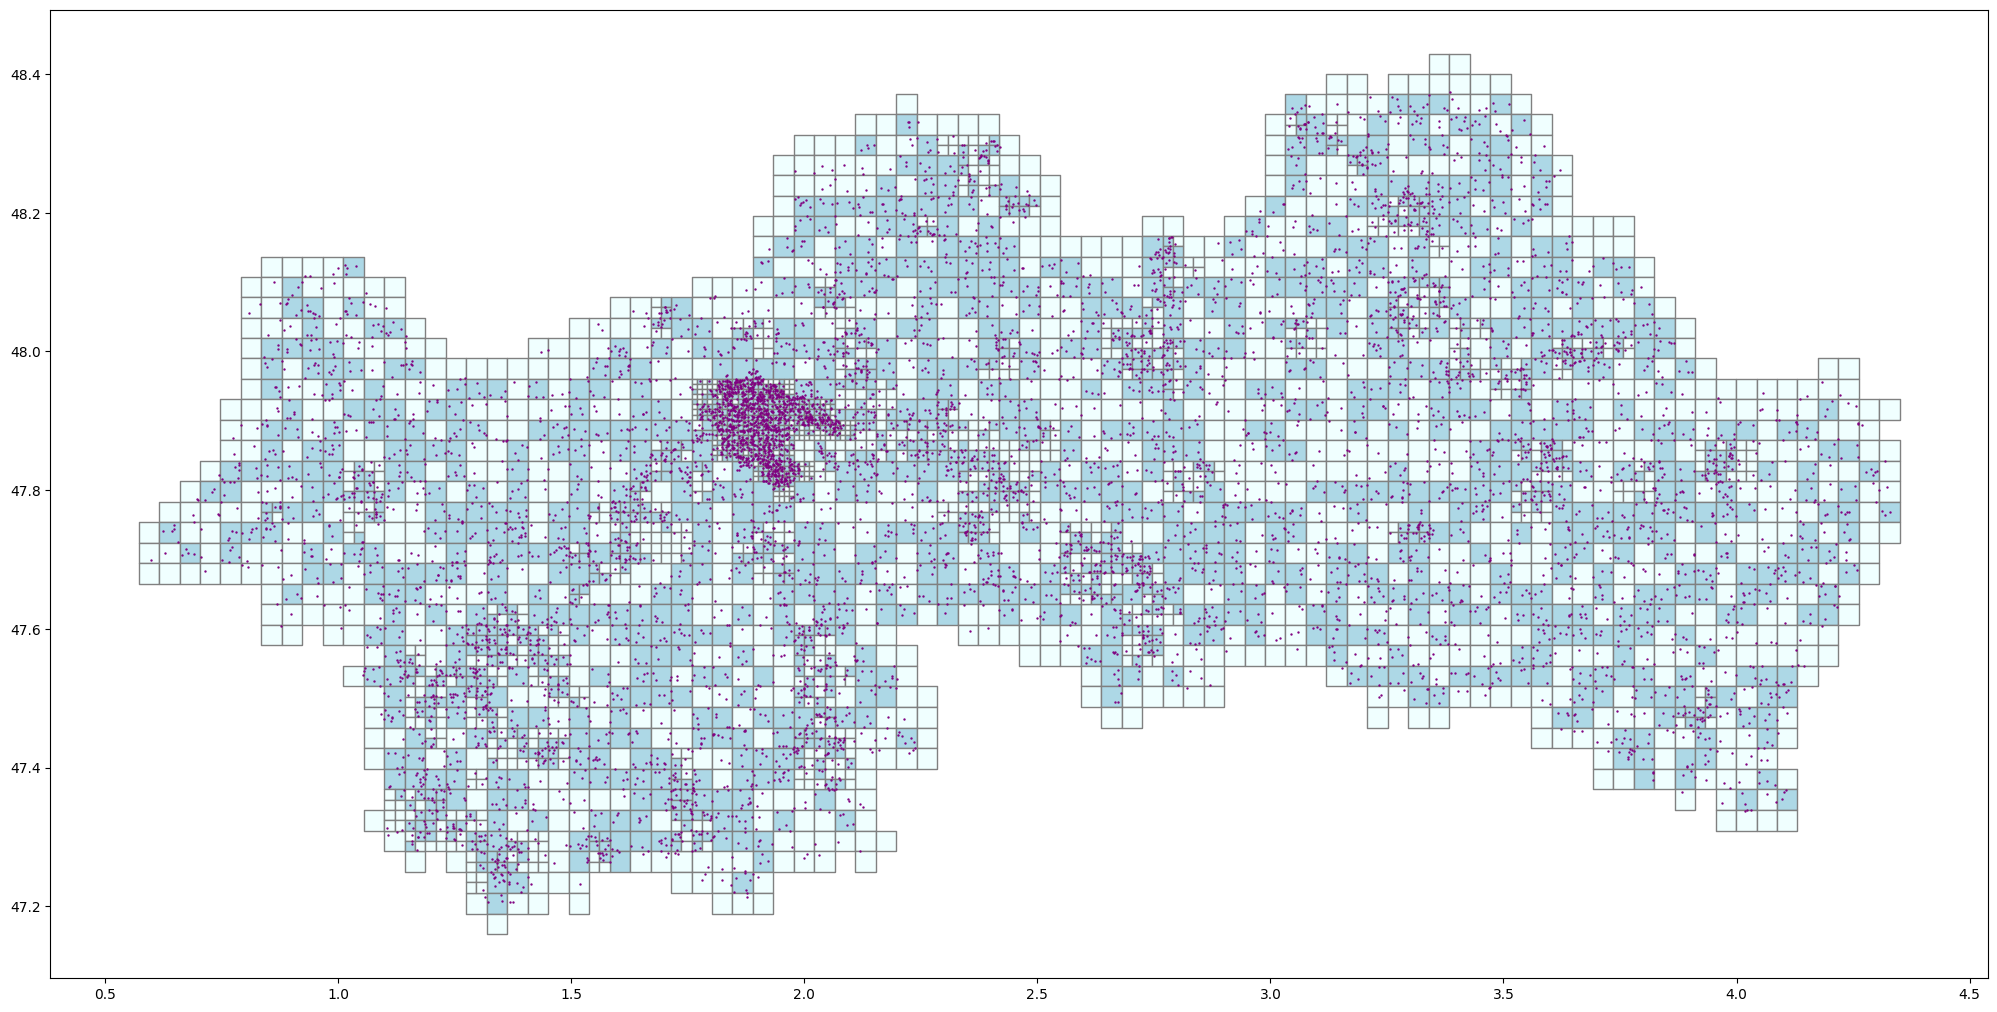

In [50]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
)
gdf_measurements_4g.plot(ax=ax, markersize=0.5, color="purple")

In [51]:
count_col_name = "5g_measurements"
tiles_with_counts = add_measurements_count(
    tiles_with_counts,
    gdf_measurements_5g,
    id_column="tile_id",
    point_count_name=count_col_name,
    threshold_use=MIN_THRESHOLD_5G,
)
tiles_with_counts.shape

(3423, 15)

<Axes: >

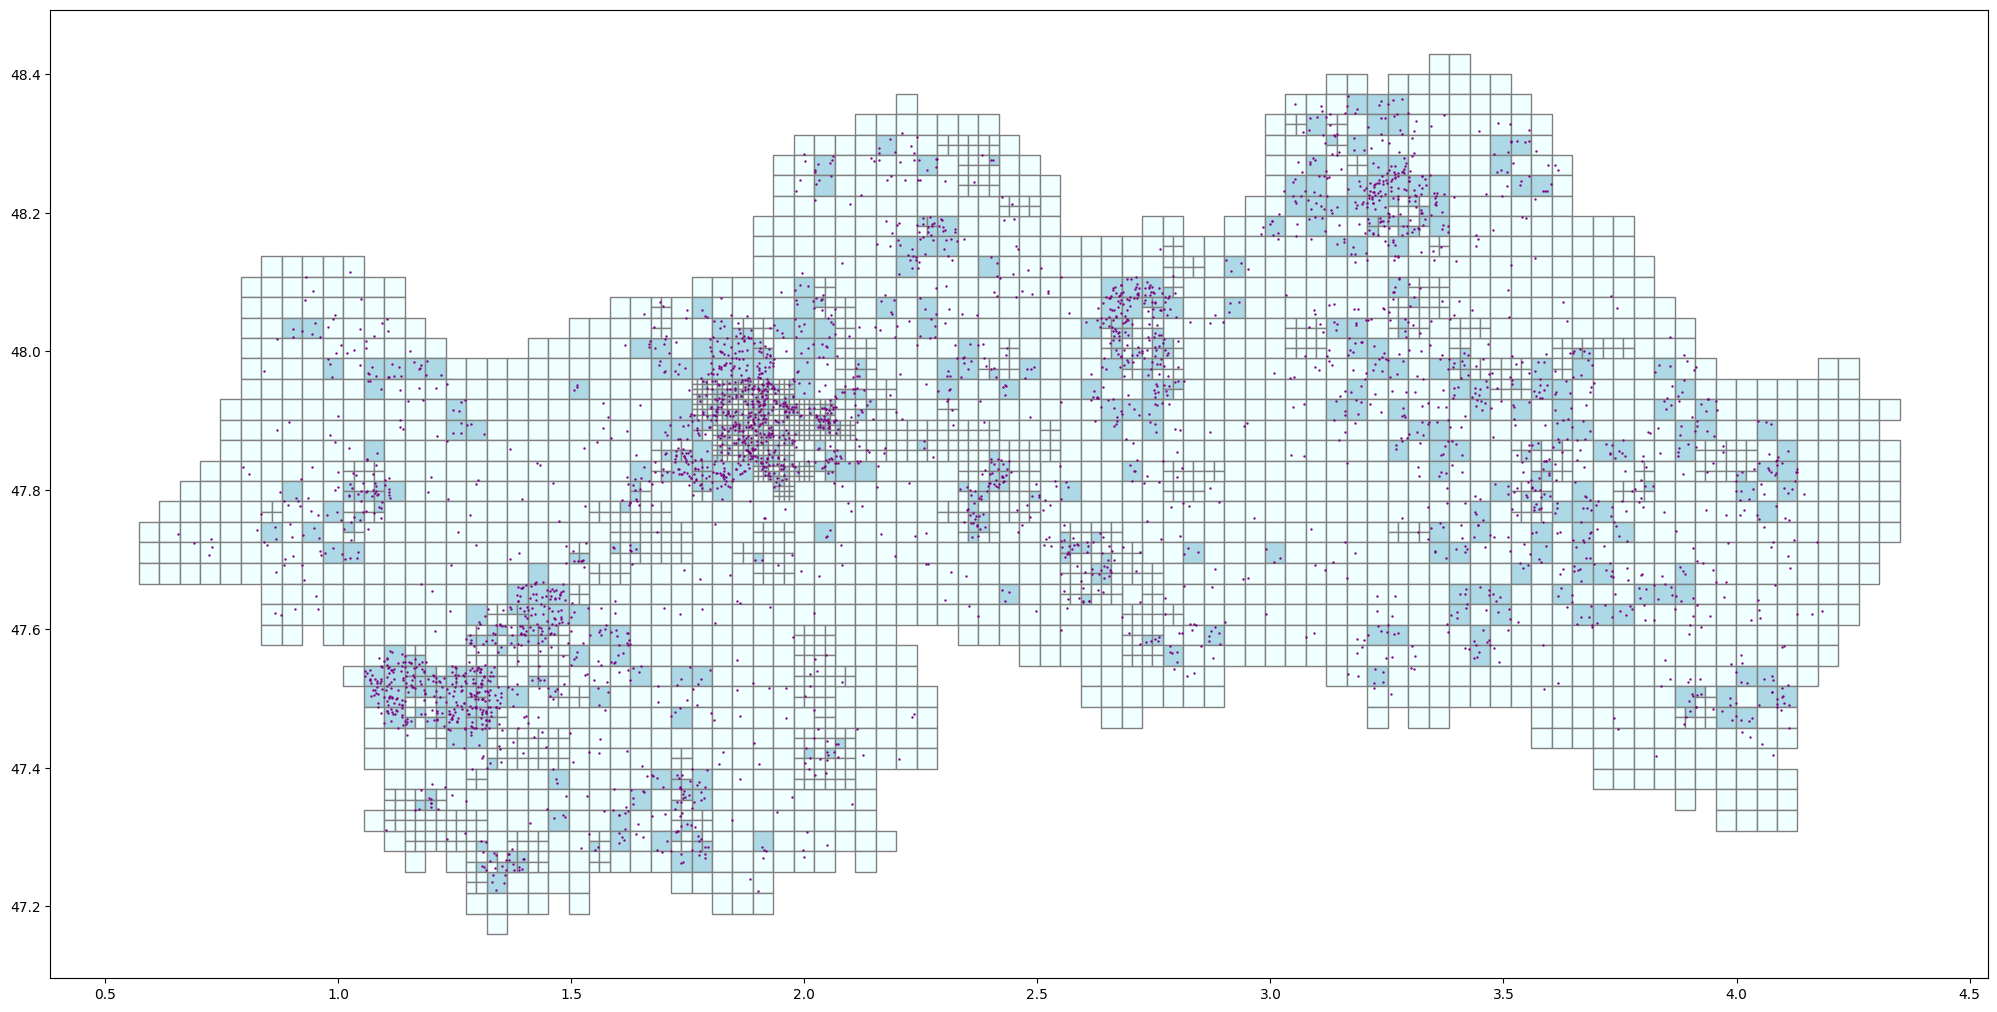

In [52]:
f, ax = plt.subplots(figsize=(25, 25))
tiles_with_counts.plot(
    ax=ax,
    edgecolor="grey",
    figsize=(25, 25),
    facecolor=tiles_with_counts[f"use_{count_col_name}"].map(get_colormap),
    linewidth=tiles_with_counts[f"use_{count_col_name}"].map(get_linewidth_map),
)
gdf_measurements_5g.plot(ax=ax, markersize=0.5, color="purple")

In [53]:
tiles_with_counts.columns

Index(['tile_id', 'geometry', 'type', 'total_measurements',
       'meandbm_total_measurements', 'operators_total_measurements',
       'use_total_measurements', '4g_measurements', 'meandbm_4g_measurements',
       'operators_4g_measurements', 'use_4g_measurements', '5g_measurements',
       'meandbm_5g_measurements', 'operators_5g_measurements',
       'use_5g_measurements'],
      dtype='object')

## Networks

In [144]:
def get_filtered_tiles(sub_df):
  filtered_tiles = sub_df.copy()
  filtered_tiles = filtered_tiles.reset_index()
  filtered_tiles = filtered_tiles.drop(columns=["index"])
  filtered_tiles["tile_id"] = filtered_tiles.index
  return filtered_tiles

In [145]:
def get_queen_network(tiles_geodataframe):
    centroids = np.column_stack(
        (
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).x,
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).y,
        )
    )
    queen = weights.Queen.from_dataframe(
        tiles_geodataframe, ids=tiles_geodataframe["tile_id"]
    )
    graph = queen.to_networkx()
    positions = dict(zip(graph.nodes, centroids))
    return graph, positions

In [146]:
def get_identify_nodes(tile_ids_to_identify):
    def identify_node(current_tile_id):
        if current_tile_id in tile_ids_to_identify:
            return "red"
        return "lightblue"

    return identify_node

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 263, 1953.
  W.__init__(self, neighbors, ids=ids, **kw)


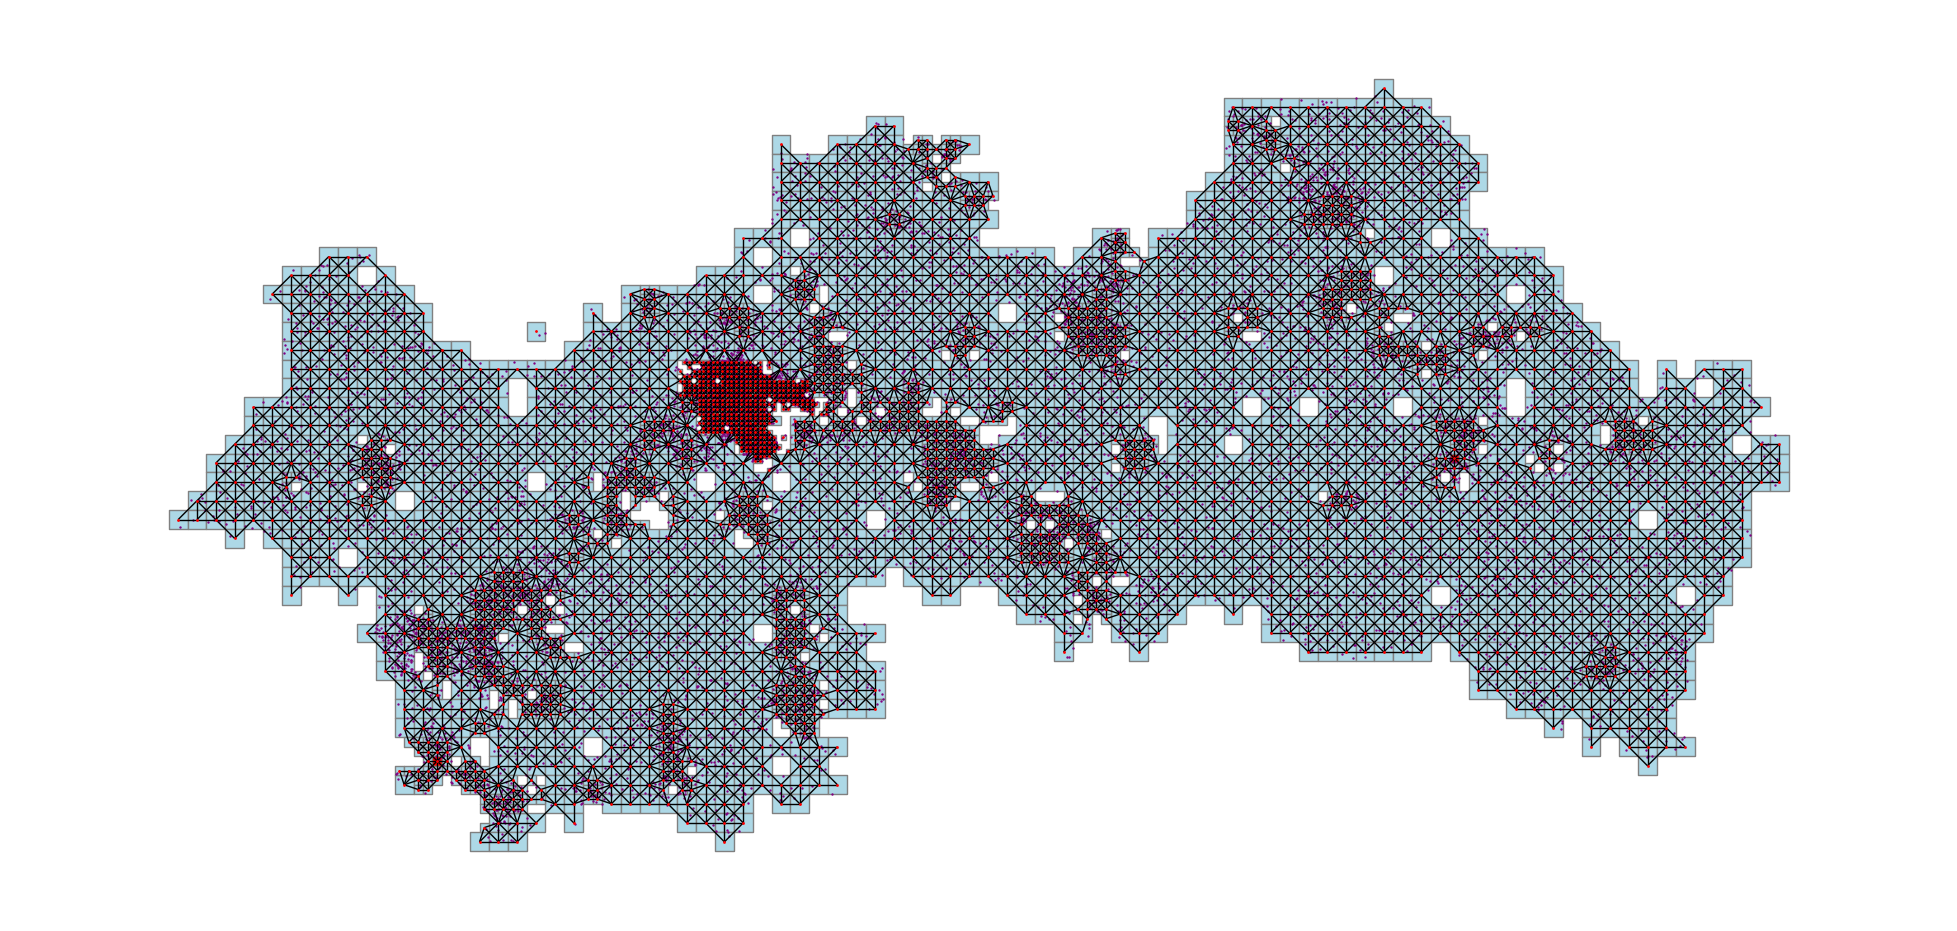

In [151]:
filtered_tiles = get_filtered_tiles(tiles_with_counts[tiles_with_counts["total_measurements"] > 0])

graph, positions = get_queen_network(filtered_tiles)
# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
# gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
filtered_tiles.plot(
    ax=ax,
    linewidth=1,
    edgecolor="grey",
    figsize=(30, 30),
    facecolor=filtered_tiles["tile_id"].map(get_identify_nodes([2060, 1736, 2927]))
)
gdf_measurements_all.plot(ax=ax, markersize=0.5, color="purple")
nx.draw(graph, positions, ax=ax, node_size=1, node_color="r")
plt.show()

In [152]:
BLOIS_TILE_ID = 2060
ORLEANS_TILE_ID = 1736
AUXERRE_TILE_ID = 2927

### Antennas

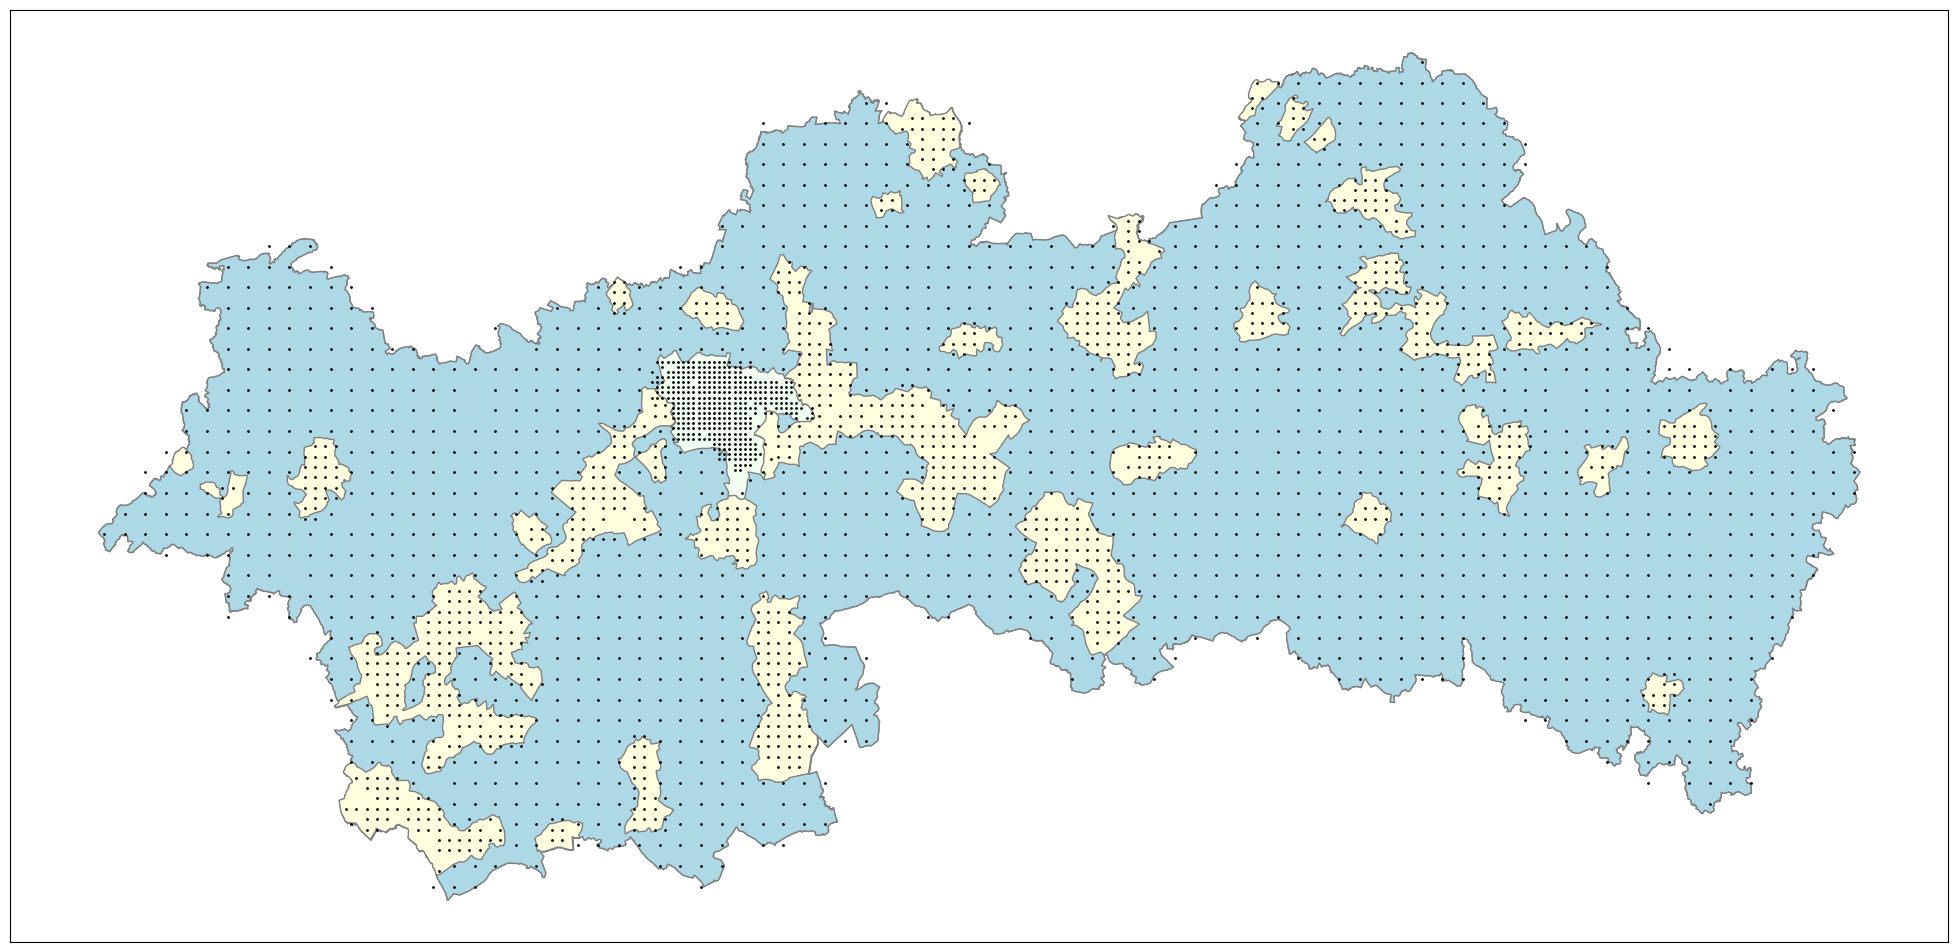

In [94]:
# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
# filtered_tiles.plot(
#   ax=ax,
#     linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor=filetered_network['tile_id'].map(get_identify_node(5))
# )
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
gdf_periurban.plot(ax=ax, edgecolor="grey", color="lightyellow")
gdf_urban.plot(ax=ax, edgecolor="grey", color="honeydew")
nx.draw_networkx_nodes(
    graph, positions, ax=ax, node_size=1, linewidths=None, node_color="black"
)
plt.show()

## Network with attributes

In [95]:
def get_queen_network(tiles_geodataframe):
    centroids = np.column_stack(
        (
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).x,
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).y,
        )
    )
    queen = weights.Queen.from_dataframe(
        tiles_geodataframe, ids=filtered_tiles["tile_id"]
    )
    graph = queen.to_networkx()
    positions = dict(zip(graph.nodes, centroids))
    nx.set_node_attributes(graph, tiles_geodataframe["type"], "type")
    nx.set_node_attributes(
        graph, tiles_geodataframe["total_measurements"], "total_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["meandbm_total_measurements"],
        "meandbm_total_measurements",
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_total_measurements"],
        "operators_total_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_total_measurements"], "use_total_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["4g_measurements"], "4g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["meandbm_4g_measurements"], "meandbm_4g_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_4g_measurements"],
        "operators_4g_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_4g_measurements"], "use_4g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["5g_measurements"], "5g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["meandbm_5g_measurements"], "meandbm_5g_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_5g_measurements"],
        "operators_5g_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_5g_measurements"], "use_5g_measurements"
    )
    return graph, positions

In [96]:
type_color_map = dict(rural="red", periurban="green", urban="blue")

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 263, 1953.
  W.__init__(self, neighbors, ids=ids, **kw)


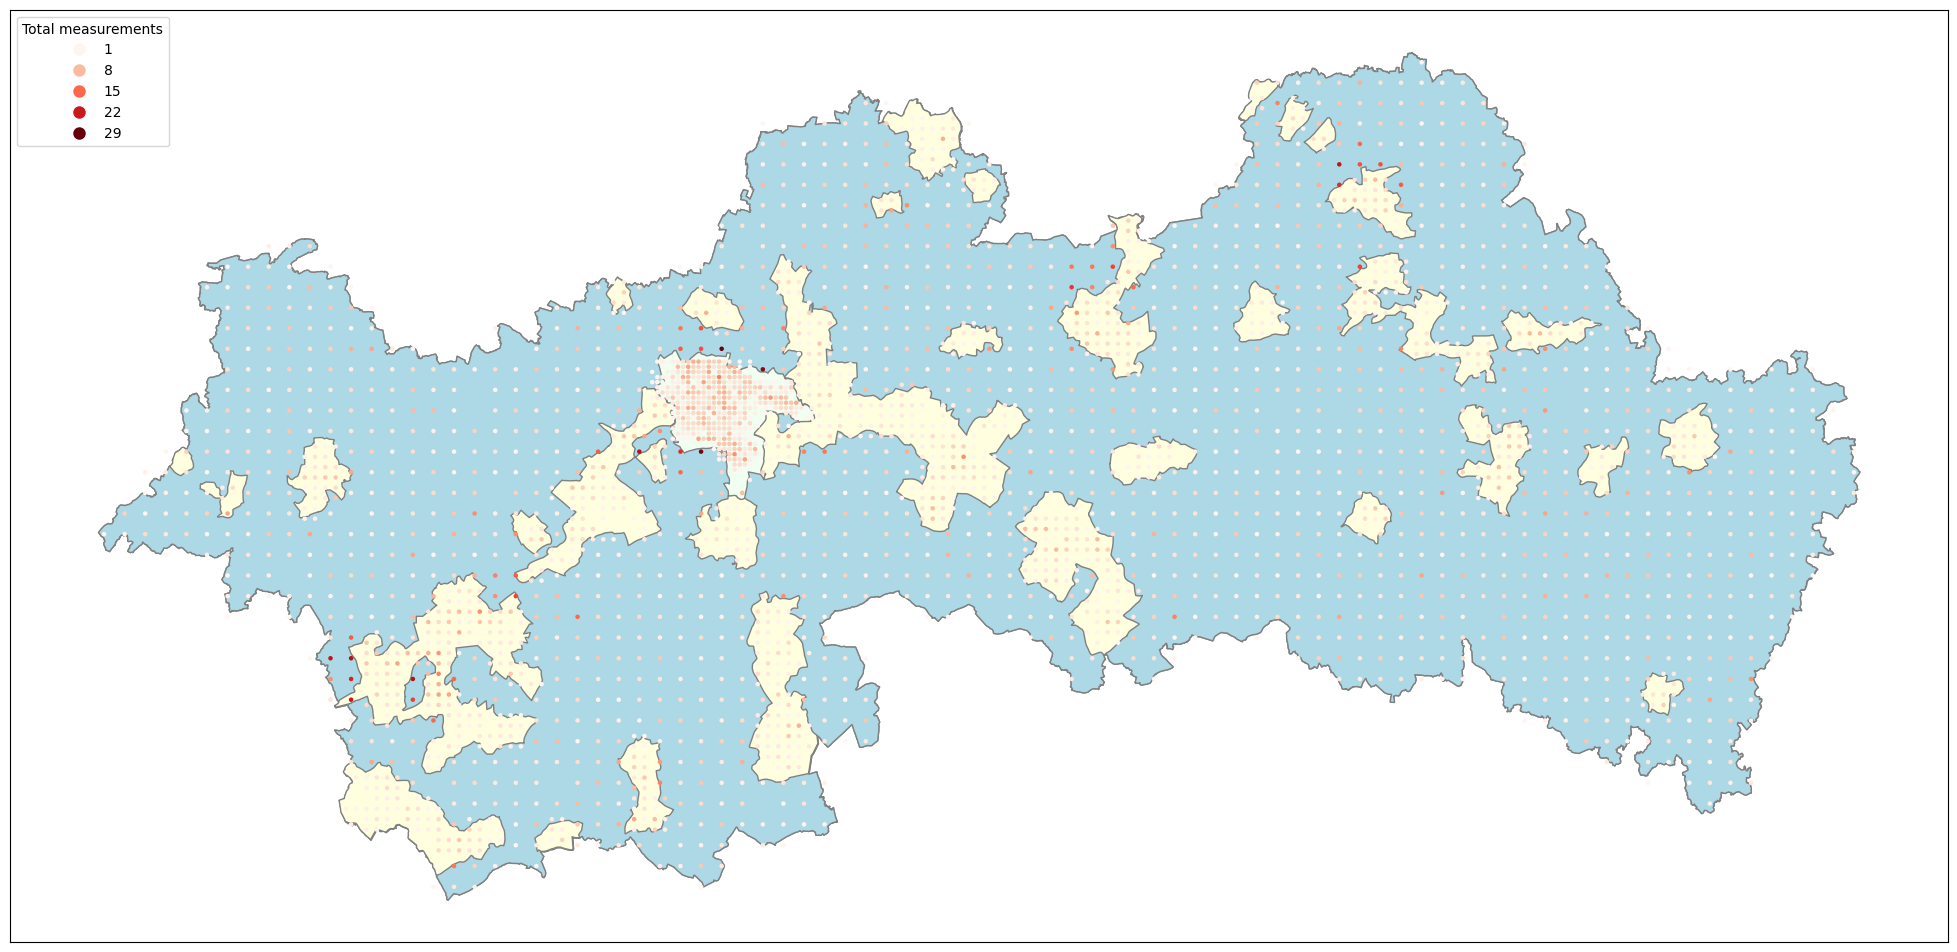

In [97]:
filtered_tiles = get_filtered_tiles(tiles_with_counts[tiles_with_counts["total_measurements"] > 0])

graph, positions = get_queen_network(filtered_tiles)

# Get node weights
node_weights = nx.get_node_attributes(graph, "total_measurements")
to_norm = np.array([v for v in node_weights.values() if not math.isnan(v)])

# Normalize weights for colormap
min_weight = min(to_norm)
max_weight = max(to_norm)
norm = plt.Normalize(min_weight, max_weight)

# Choose a colormap
cmap = plt.cm.Reds

# Create a ScalarMappable to map values to colors
sm = ScalarMappable(norm=norm, cmap=cmap)

# Get colors for nodes based on their weights
node_colors = [sm.to_rgba(weight) for weight in node_weights.values()]

# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
# filtered_tiles.plot(
#   ax=ax,
#     linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor=filetered_network['tile_id'].map(get_identify_node(5))
# )
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
gdf_periurban.plot(ax=ax, edgecolor="grey", color="lightyellow")
gdf_urban.plot(ax=ax, edgecolor="grey", color="honeydew")
# gdf_measurements_all.plot(ax=ax, markersize=0.2, color="purple")
nx.draw_networkx_nodes(
    graph, positions, ax=ax, node_size=5, linewidths=None, node_color=node_colors
)
# legend
sample_measurements = np.linspace(min_weight, max_weight, num=5, dtype=int)
legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markersize=10,
        markerfacecolor=sm.to_rgba(msr),
    )
    for msr in sample_measurements
]
legend_labels = [f"{msr}" for msr in sample_measurements]
plt.legend(legend_handles, legend_labels, title="Total measurements", loc="upper left")
plt.show()

### With avg 5g signal strength

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 263, 1953.
  W.__init__(self, neighbors, ids=ids, **kw)


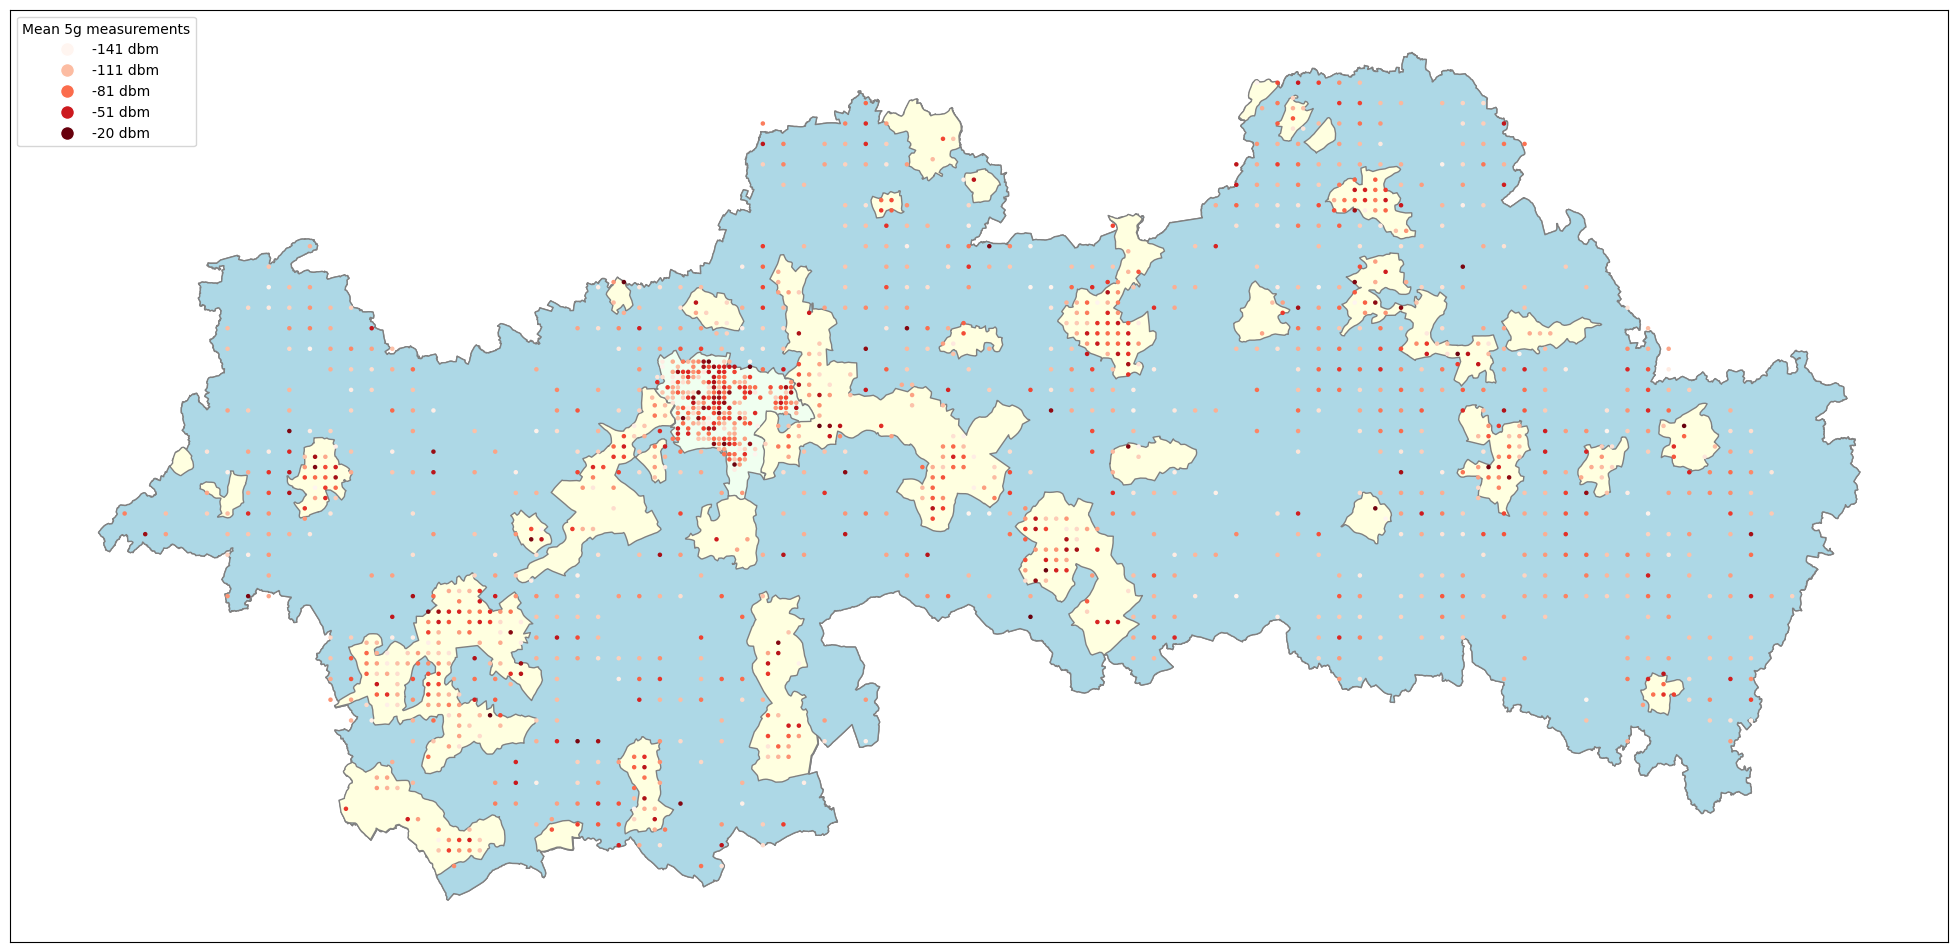

In [98]:
filtered_tiles = get_filtered_tiles(tiles_with_counts[tiles_with_counts["total_measurements"] > 0])

graph, positions = get_queen_network(filtered_tiles)

# Get node weights
node_weights = nx.get_node_attributes(graph, "meandbm_5g_measurements")
to_norm = np.array([v for v in node_weights.values() if not math.isnan(v)])

# Normalize weights for colormap
min_weight = min(to_norm)
max_weight = max(to_norm)
norm = plt.Normalize(min_weight, max_weight)

# Choose a colormap
cmap = plt.cm.Reds

# Create a ScalarMappable to map values to colors
sm = ScalarMappable(norm=norm, cmap=cmap)

# Get colors for nodes based on their weights
node_colors = [sm.to_rgba(weight) for weight in node_weights.values()]

# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
# filtered_tiles.plot(
#   ax=ax,
#     linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor=filetered_network['tile_id'].map(get_identify_node(5))
# )
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
gdf_periurban.plot(ax=ax, edgecolor="grey", color="lightyellow")
gdf_urban.plot(ax=ax, edgecolor="grey", color="honeydew")
# gdf_measurements_all.plot(ax=ax, markersize=0.2, color="purple")
nx.draw_networkx_nodes(
    graph, positions, ax=ax, node_size=5, linewidths=None, node_color=node_colors
)
# legend
sample_measurements = np.linspace(min_weight, max_weight, num=5, dtype=int)
legend_handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markersize=10,
        markerfacecolor=sm.to_rgba(msr),
    )
    for msr in sample_measurements
]
legend_labels = [f"{msr} dbm" for msr in sample_measurements]
plt.legend(legend_handles, legend_labels, title="Mean 5g measurements", loc="upper left")
plt.show()

## Best path

### calculate graph

In [167]:
def get_queen_network(tiles_geodataframe, edge_processing_function=None):
    centroids = np.column_stack(
        (
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).x,
            tiles_geodataframe.to_crs(epsg=4087).centroid.to_crs(epsg=4326).y,
        )
    )
    queen = weights.Queen.from_dataframe(
        tiles_geodataframe, ids=filtered_tiles["tile_id"]
    )
    graph = queen.to_networkx()
    graph = nx.DiGraph(graph)
    positions = dict(zip(graph.nodes, centroids))
    nx.set_node_attributes(graph, tiles_geodataframe["type"], "type")
    nx.set_node_attributes(
        graph, tiles_geodataframe["total_measurements"], "total_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["meandbm_total_measurements"],
        "meandbm_total_measurements",
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_total_measurements"],
        "operators_total_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_total_measurements"], "use_total_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["4g_measurements"], "4g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["meandbm_4g_measurements"], "meandbm_4g_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_4g_measurements"],
        "operators_4g_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_4g_measurements"], "use_4g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["5g_measurements"], "5g_measurements"
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["meandbm_5g_measurements"], "meandbm_5g_measurements"
    )
    nx.set_node_attributes(
        graph,
        tiles_geodataframe["operators_5g_measurements"],
        "operators_5g_measurements",
    )
    nx.set_node_attributes(
        graph, tiles_geodataframe["use_5g_measurements"], "use_5g_measurements"
    )
    if edge_processing_function is not None:
      edge_processing_function(graph)
    return graph, positions

### process edges

In [195]:
def set_weight(graph):
  to_remove = []
  for node in graph.nodes():
    if graph.nodes[node]['use_5g_measurements'] or graph.nodes[node]['use_4g_measurements']:
      if graph.nodes[node]['use_5g_measurements']:
        node_dbm = graph.nodes[node]['meandbm_5g_measurements']
      else:
        node_dbm = graph.nodes[node]['meandbm_4g_measurements']

      if np.isnan(node_dbm):
        to_remove.append(node)
      else:
        for predecessor in graph.predecessors(node):
          graph[predecessor][node]['weight'] = -1 * node_dbm

    else:
      to_remove.append(node)
  
  for n in to_remove:
    graph.remove_node(n)


In [196]:
filtered_tiles = get_filtered_tiles(tiles_with_counts[tiles_with_counts["total_measurements"] > 0])
graph, positions = get_queen_network(filtered_tiles, set_weight)

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 263, 1953.
  W.__init__(self, neighbors, ids=ids, **kw)


In [197]:
best_path_a = nx.shortest_path(graph, source=BLOIS_TILE_ID, target=ORLEANS_TILE_ID, weight='weight')
best_path_b = nx.shortest_path(graph, source=ORLEANS_TILE_ID, target=AUXERRE_TILE_ID, weight='weight')
best_path = best_path_a + best_path_b[1:]

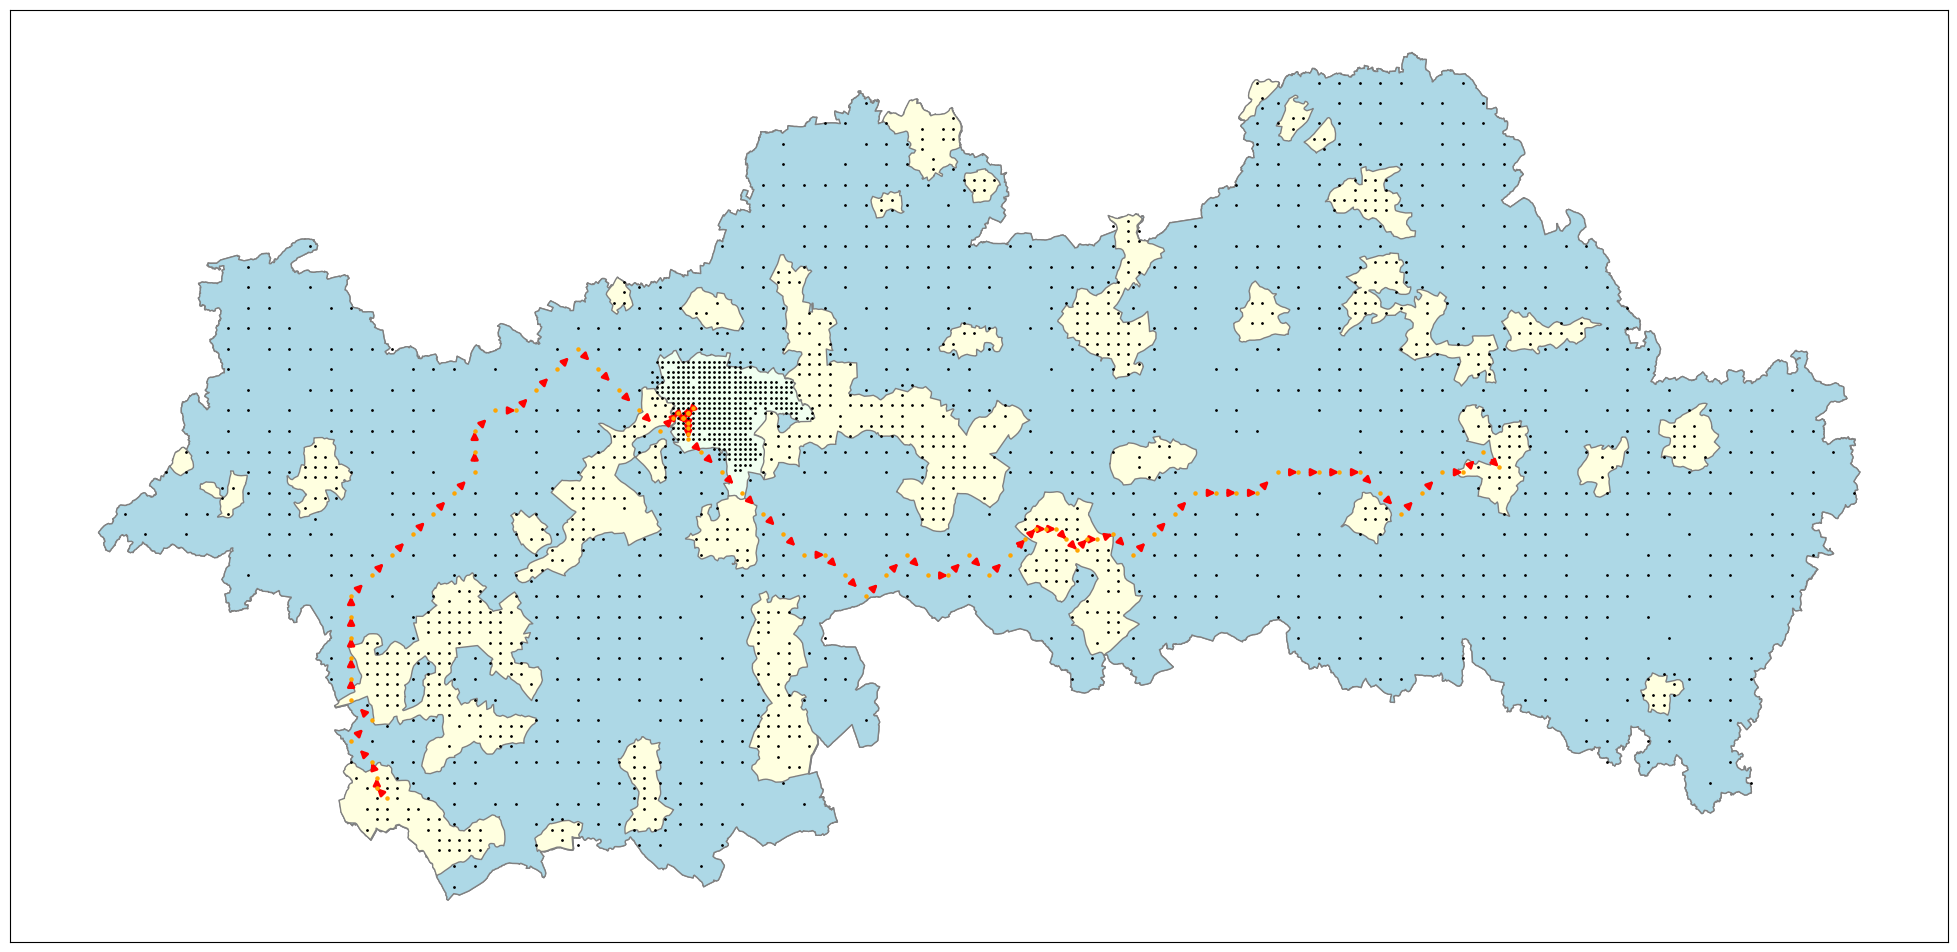

In [198]:
# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
# filtered_tiles.plot(
#   ax=ax,
#     linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor=filetered_network['tile_id'].map(get_identify_node(5))
# )
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
gdf_periurban.plot(ax=ax, edgecolor="grey", color="lightyellow")
gdf_urban.plot(ax=ax, edgecolor="grey", color="honeydew")
nx.draw_networkx_nodes(
    graph, positions, ax=ax, node_size=1, linewidths=None, node_color="black"
)
path_edges = list(zip(best_path, best_path[1:]))
nx.draw_networkx_nodes(graph, positions, nodelist=best_path, node_color='orange', node_size=5)
nx.draw_networkx_edges(graph, positions, edgelist=path_edges, edge_color='red', width=2)
plt.show()

### Penalize 4g

In [199]:
def set_weight_penalize_4g(graph):
  to_remove = []
  for node in graph.nodes():
    if graph.nodes[node]['use_5g_measurements'] or graph.nodes[node]['use_4g_measurements']:
      if graph.nodes[node]['use_5g_measurements']:
        node_dbm = graph.nodes[node]['meandbm_5g_measurements']
      else:
        node_dbm = graph.nodes[node]['meandbm_4g_measurements'] - 1000

      if np.isnan(node_dbm):
        to_remove.append(node)
      else:
        for predecessor in graph.predecessors(node):
          graph[predecessor][node]['weight'] = -1 * node_dbm

    else:
      to_remove.append(node)
  
  for n in to_remove:
    graph.remove_node(n)


In [202]:
filtered_tiles = get_filtered_tiles(tiles_with_counts[tiles_with_counts["total_measurements"] > 0])
graph, positions = get_queen_network(filtered_tiles, set_weight_penalize_4g)
best_path_a = nx.shortest_path(graph, source=BLOIS_TILE_ID, target=ORLEANS_TILE_ID, weight='weight')
best_path_b = nx.shortest_path(graph, source=ORLEANS_TILE_ID, target=AUXERRE_TILE_ID, weight='weight')
best_path = best_path_a + best_path_b[1:]

/home/lu1sd4/.pyenv/versions/3.10.9/envs/frhack/lib/python3.10/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 263, 1953.
  W.__init__(self, neighbors, ids=ids, **kw)


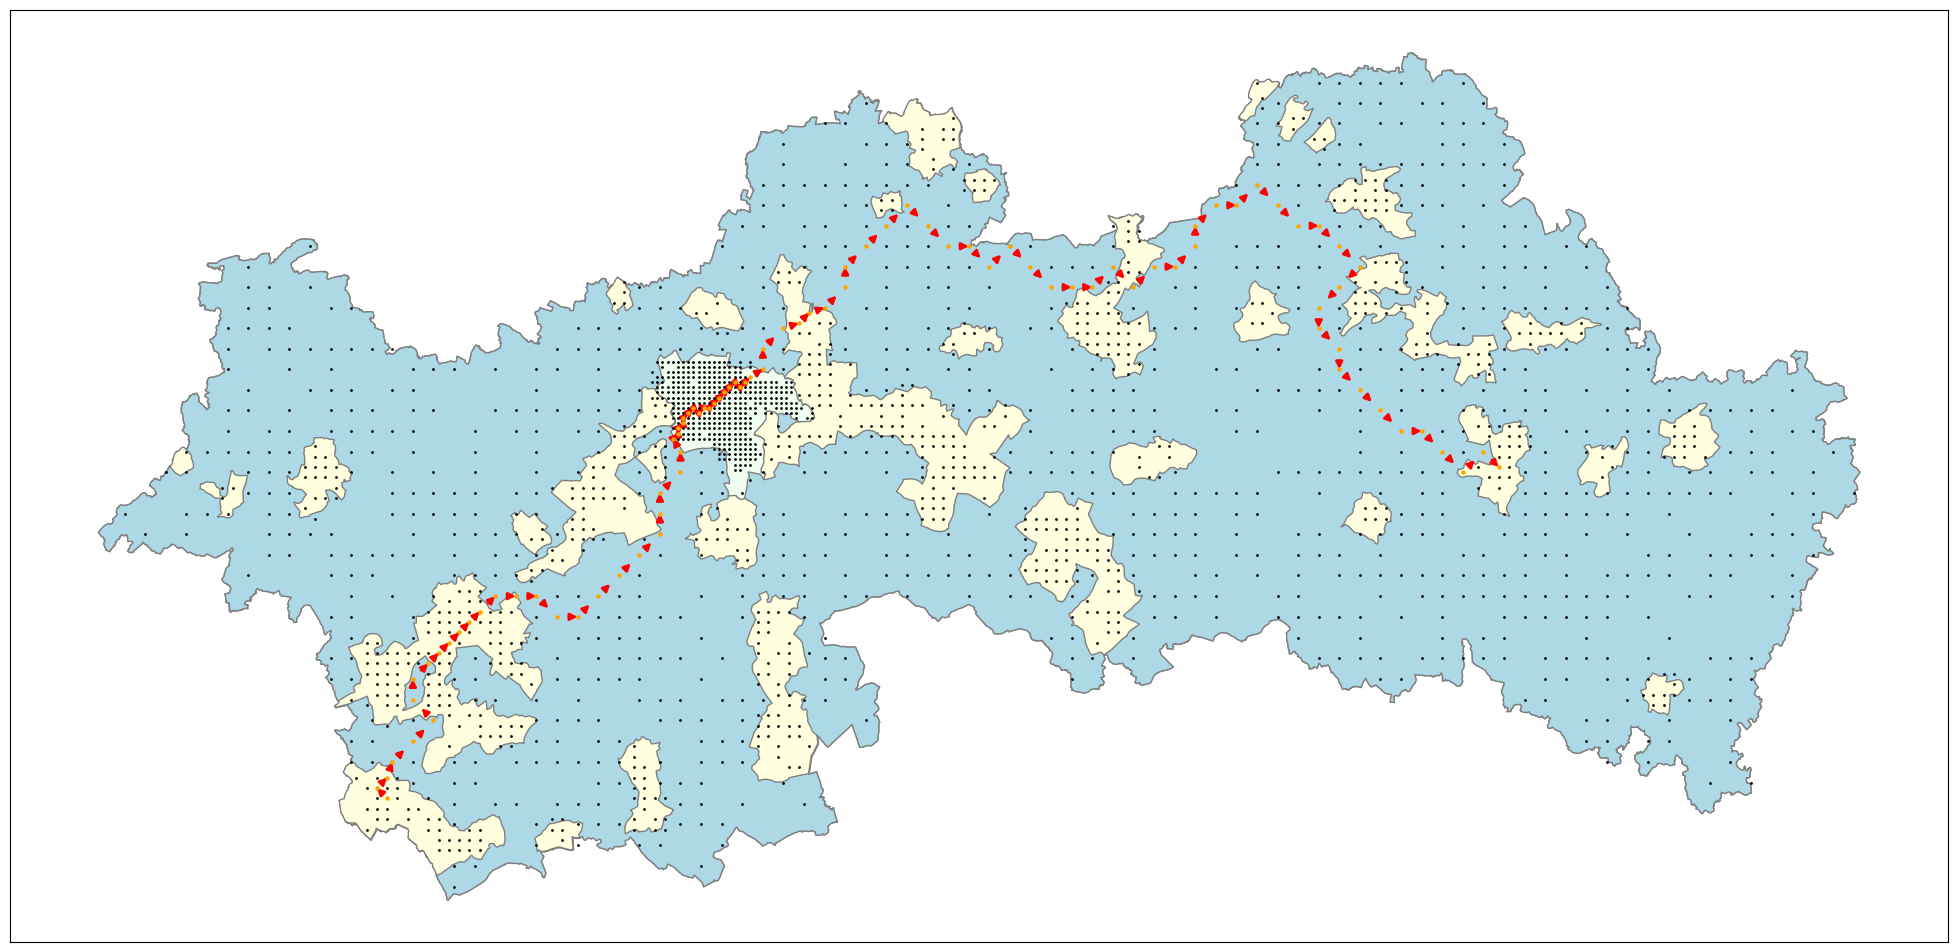

In [203]:
# plot with a nice basemap
f, ax = plt.subplots(figsize=(25, 25))
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
# filtered_tiles.plot(
#   ax=ax,
#     linewidth=1, edgecolor="grey", figsize=(30, 30), facecolor=filetered_network['tile_id'].map(get_identify_node(5))
# )
gdf_all.plot(ax=ax, linewidth=1, edgecolor="grey", color="lightblue")
gdf_periurban.plot(ax=ax, edgecolor="grey", color="lightyellow")
gdf_urban.plot(ax=ax, edgecolor="grey", color="honeydew")
nx.draw_networkx_nodes(
    graph, positions, ax=ax, node_size=1, linewidths=None, node_color="black"
)
path_edges = list(zip(best_path, best_path[1:]))
nx.draw_networkx_nodes(graph, positions, nodelist=best_path, node_color='orange', node_size=5)
nx.draw_networkx_edges(graph, positions, edgelist=path_edges, edge_color='red', width=2)
plt.show()